In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# coding:utf-8
'''
author:
    zhangzhaopeng
usage:
    AFAGPS算法计算功率谱
attention:
    get_extremum, get_AFAGPS_graph为辅助功能,
    与功率谱计算无关系.
'''


__author__ = 'zhangzhaopeng'


def get_extremum(xx, yy, key=max, n=10):
    """
    获得至多n个极值, 如果key=max则获得极大值,
    如果key=min则获得极小值.

    Parameters
    ----------
    xx: list
        x axis data
    yy: list
        y axis data
    key: func
        default: max
        key for  extremum.
    n: int
        default: 10
        at most n extremum.

    Returns
    -------
    a list of at most n numbers.
    """
    if n == 0:
        return [()]
    data = []
    for x, y, idx in zip(xx, yy, range(len(xx))):
        if y != 0:
            data.append((x, y, idx))
    extremums = []
    cutoff = int(len(data) * 1.0 / n)
    for i in range(n):
        start = i * cutoff
        end = (1 + i) * cutoff
        x, y, idx = key(data[start:end], key=lambda t: t[1])
        if idx + 1 < len(yy):
            if key(yy[idx], yy[idx + 1], yy[idx - 1]) == yy[idx]:
                extremums.append((x, y, idx))
        else:
            extremums.append((x, y, idx))
    return extremums


def get_AFAGPS_graph(picName, x, y=None, h=0.2, style=None):
    """
    作功率谱图像

    Parameters
    ----------
    picName: str
        default: None
        图像名称
    x,y:
        若y为None，则计算列表x的功率谱结果并作图;
        否则，直接以x,y的值作图
    h:
        指定AFAGPS算法中过滤系数
    style:
        如果为'D'则作竖线图

    Returns
    -------
    exs: list
        极值对.
    """
    if y == None:
        xx, yy = get_AFAGPS(x, h)
    else:
        xx, yy = x, y
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D
    max_yy = max(yy)
    yy = [y / max_yy for y in yy]
    fig = plt.figure(figsize=(10, 10), dpi=300)
    #plt.plot(xx, yy)
    ax = fig.add_subplot(111)
    exs = []
    for i in range(1, len(xx) - 1):
        if yy[i] > yy[i-1] and yy[i] > yy[i+1]:
            exs.append((xx[i], yy[i], i))
            if style == 'D':
                ax.add_line(Line2D((xx[i], xx[i]), (0, yy[i]), color='red'))
    if style != 'D':
        ax.scatter(xx, yy, linewidths=0.01)

    plt.xlim(0, 2 * np.pi)
    plt.ylim(0, 1.1)
    plt.xticks((0, np.pi / 2, np.pi, 3 * np.pi / 2, 2 * np.pi),
               (r"$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{4}$", r"$2\pi$"))

    plt.savefig("C:\\Users\\Lenovo\\Desktop\\气象水文\\afagps计算功率谱\\"+picName+".png")
    plt.close()
    return exs, max_yy


def listConvolve(x, y):
    """
    calculate linear convolution of two lists.

    Attention
    ---------
        len(x)=m, len(y)=n, m<=n
        return n length list: circular convolution of x and y
    """
    ########## old #################
    #result = np.convolve(x, y)[len(x)-1:len(y)]
    ########## new #################
    x.extend([0] * (len(y) - len(x)))
    result = np.fft.ifft(np.fft.fft(x) * np.fft.fft(y)).real
    return result


def get_AFAGPS(X, tag='D', h=0.2):
    '''
    Parameters
    ----------
    X: list
        需要计算功率谱的数据
    tag: str
    default: D
        C: continuous Fourier Transform
        D: Discrete Fourier Transfrom
    h: float
        指定AFAGPS算法中过滤系数

    Examples
    --------
    ref to test.py
    '''
    X, N = [float(i) for i in X], len(X)
    # normalized
    mean, std = np.mean(X), np.std(X)
   # X = [(i - mean) / std for i in X]
    # reverse X
    X_reverse = X[::-1]
    # add zeros
    X_reverse.extend([0] * N)
    X=X_reverse[::-1]
	
    # circular convolution, the same as matlab function "cconv"
    Rn = listConvolve(X, X_reverse)
    Rn = [1.0 / (N-i) * Rn[i] for i in range(1000)]   ######change1
    # filt
    for idx, i in enumerate(Rn):
        if abs(i / Rn[0]) <= h:
            Rn[idx] = 0
    # add zeros
    #Rn.extend(len(Rn) * [0])    ########change2

    plist = [2 * value.real - Rn[0] for value in np.fft.fft(Rn)]
    #m = max([abs(i) for i in plist])
    #plist = [abs(i) / m for i in plist]

    if tag == 'C':
        """CFT"""
        yy = [i + j for i,
              j in zip(plist[len(plist) // 2 + 1:], plist[:len(plist) // 2 + 1])]
    elif tag == 'D':
        """DFT"""
        yy = plist
    '''
    else:
        import sys
        print("Error!")
        sys.exit(1)
        '''
    xx = []
    for i in range(len(yy)):
        xx.append(i * np.pi / len(yy))
    return xx, yy

def get_abs2_ps(X):
    """
    only for DFT.
    """
    X, N = [float(i) for i in X], len(X)
    # normalized
    mean, std = np.mean(X), np.std(X)
    X = [(i - mean) / std for i in X]
    R = np.fft.fft(X)
    absR = [abs(r)**2 for r in R]
    m = np.mean(absR)
    for idx, r in enumerate(absR):
        if r < m:
            absR[idx] = 0.
    xx = []
    for i in range(len(absR)):
        xx.append(i * 2 * np.pi / len(absR))
    return xx, absR

In [4]:
da=pd.read_csv(r'D:\e\南开光伏课题数据集及说明\NK2_GF\评测数据\气象数据\Station_1.csv')
da=np.array(da)
da
c1=da[0:10000,2]
c2=da[0:10000,3]
c3=da[0:10000,4]
c4=da[0:10000,5]
c5=da[0:10000,6]
#ax,ay=get_AFAGPS(c1,h=0.2)
#max_ay = max(ay)
#ay = [y / max_ay for y in ay]
#plt.figure(figsize=(40,10))
#plt.plot(ax,ay)

In [5]:
def get_AFAGPS(X, tag='D', h=0.2):
    '''
    Parameters
    ----------
    X: list
        需要计算功率谱的数据
    tag: str
    default: D
        C: continuous Fourier Transform
        D: Discrete Fourier Transfrom
    h: float
        指定AFAGPS算法中过滤系数

    Examples
    --------
    ref to test.py
    '''
    X, N = [float(i) for i in X], len(X)
    # normalized
    mean, std = np.mean(X), np.std(X)
    X = [(i - mean) / std for i in X]
    # reverse X
    X_reverse = X[::-1]
    # add zeros
    X_reverse.extend([0] * N)
    X=X_reverse[::-1]
	
    # circular convolution, the same as matlab function "cconv"
    Rn = listConvolve(X, X_reverse)
    Rn = [1.0 / (N-i) * Rn[i] for i in range(1000)]   ######change1
    # filt
    for idx, i in enumerate(Rn):
        if abs(i / Rn[0]) <= h:
            Rn[idx] = 0
    # add zeros
    Rn.extend(len(Rn) * [0])    ########change2

    plist = [2 * value.real - Rn[0] for value in np.fft.fft(Rn)]
    m = max([abs(i) for i in plist])
    plist = [abs(i) / m for i in plist]

    if tag == 'C':
        """CFT"""
        yy = [i + j for i,
              j in zip(plist[len(plist) // 2 + 1:], plist[:len(plist) // 2 + 1])]
    elif tag == 'D':
        """DFT"""
        yy = plist
    '''
    else:
        import sys
        print("Error!")
        sys.exit(1)
        '''
    xx = []
    for i in range(len(yy)):
        xx.append(i * np.pi / len(yy))
    return xx, yy

In [6]:
def sfgps(X):
    X, N = [float(i) for i in X], len(X)
    # normalized
    mean, std = np.mean(X), np.std(X)
    X = [(i - mean) / std for i in X]
    yy=(abs(np.fft.fft(X)))**2
    ave=1/(N+1)*sum(X)
    y=list()
    for m in yy:
        if m>ave+std:
            y.append(m)
        else:
            y.append(std**2)
    return y

In [71]:
def getsfgps(X,name):
    y=sfgps(X)
    max_y = max(y)
    y = [ay / max_y for ay in y]
    x=range(0,10000)
    plt.figure(figsize=(30,10),dpi=300)
    plt.bar(x,y,1)
    #plt.plot(y)
    plt.savefig("C:\\Users\\Lenovo\\Desktop\\气象水文\\afagps功率谱new\\"+name+".png")
    return y

In [72]:
cc1=da[0:10000,2]
cc2=da[0:10000,3]
cc3=da[0:10000,4]
cc4=da[0:10000,5]
cc5=da[0:10000,6]

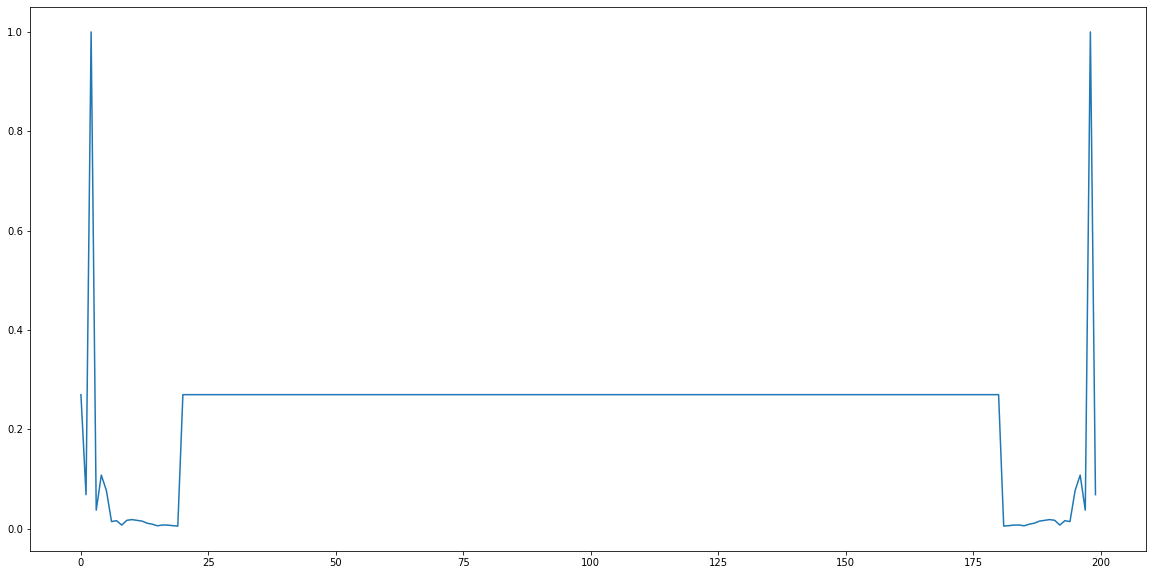

In [26]:
getsfgps(cc2,'第二列')

[1.0230715814357666e-06,
 1.0,
 0.05277763536929649,
 0.31108913688481254,
 0.13114954099171924,
 0.06239812791560941,
 0.1269490909323296,
 0.011493451166809335,
 0.026106758056159092,
 0.0418761621495371,
 0.019206369222061485,
 0.053695619955893614,
 0.02631052480817395,
 0.042034713292790384,
 0.048839935714031564,
 0.011575408833740797,
 0.04000987618168886,
 0.05161066100703081,
 0.019614340844482842,
 0.007259184440059249,
 0.01862312293507165,
 0.027030490969775396,
 0.017659236640036734,
 0.0034475313478701673,
 0.025393059399877852,
 0.01233648658988633,
 0.02524909687175883,
 0.004072122142041338,
 0.010227381378063402,
 0.019903904735793943,
 0.0018238245318646638,
 0.01713813268967934,
 0.0026189783805643,
 0.007890424099891576,
 0.0012725840078138193,
 0.0032160524029830346,
 0.0003200111266576641,
 0.0009797444535069022,
 0.0008562593028537881,
 0.0021707799998706033,
 0.001703470442737351,
 0.0015004505477688936,
 0.013352034050155365,
 0.00012199143500380718,
 0.001409

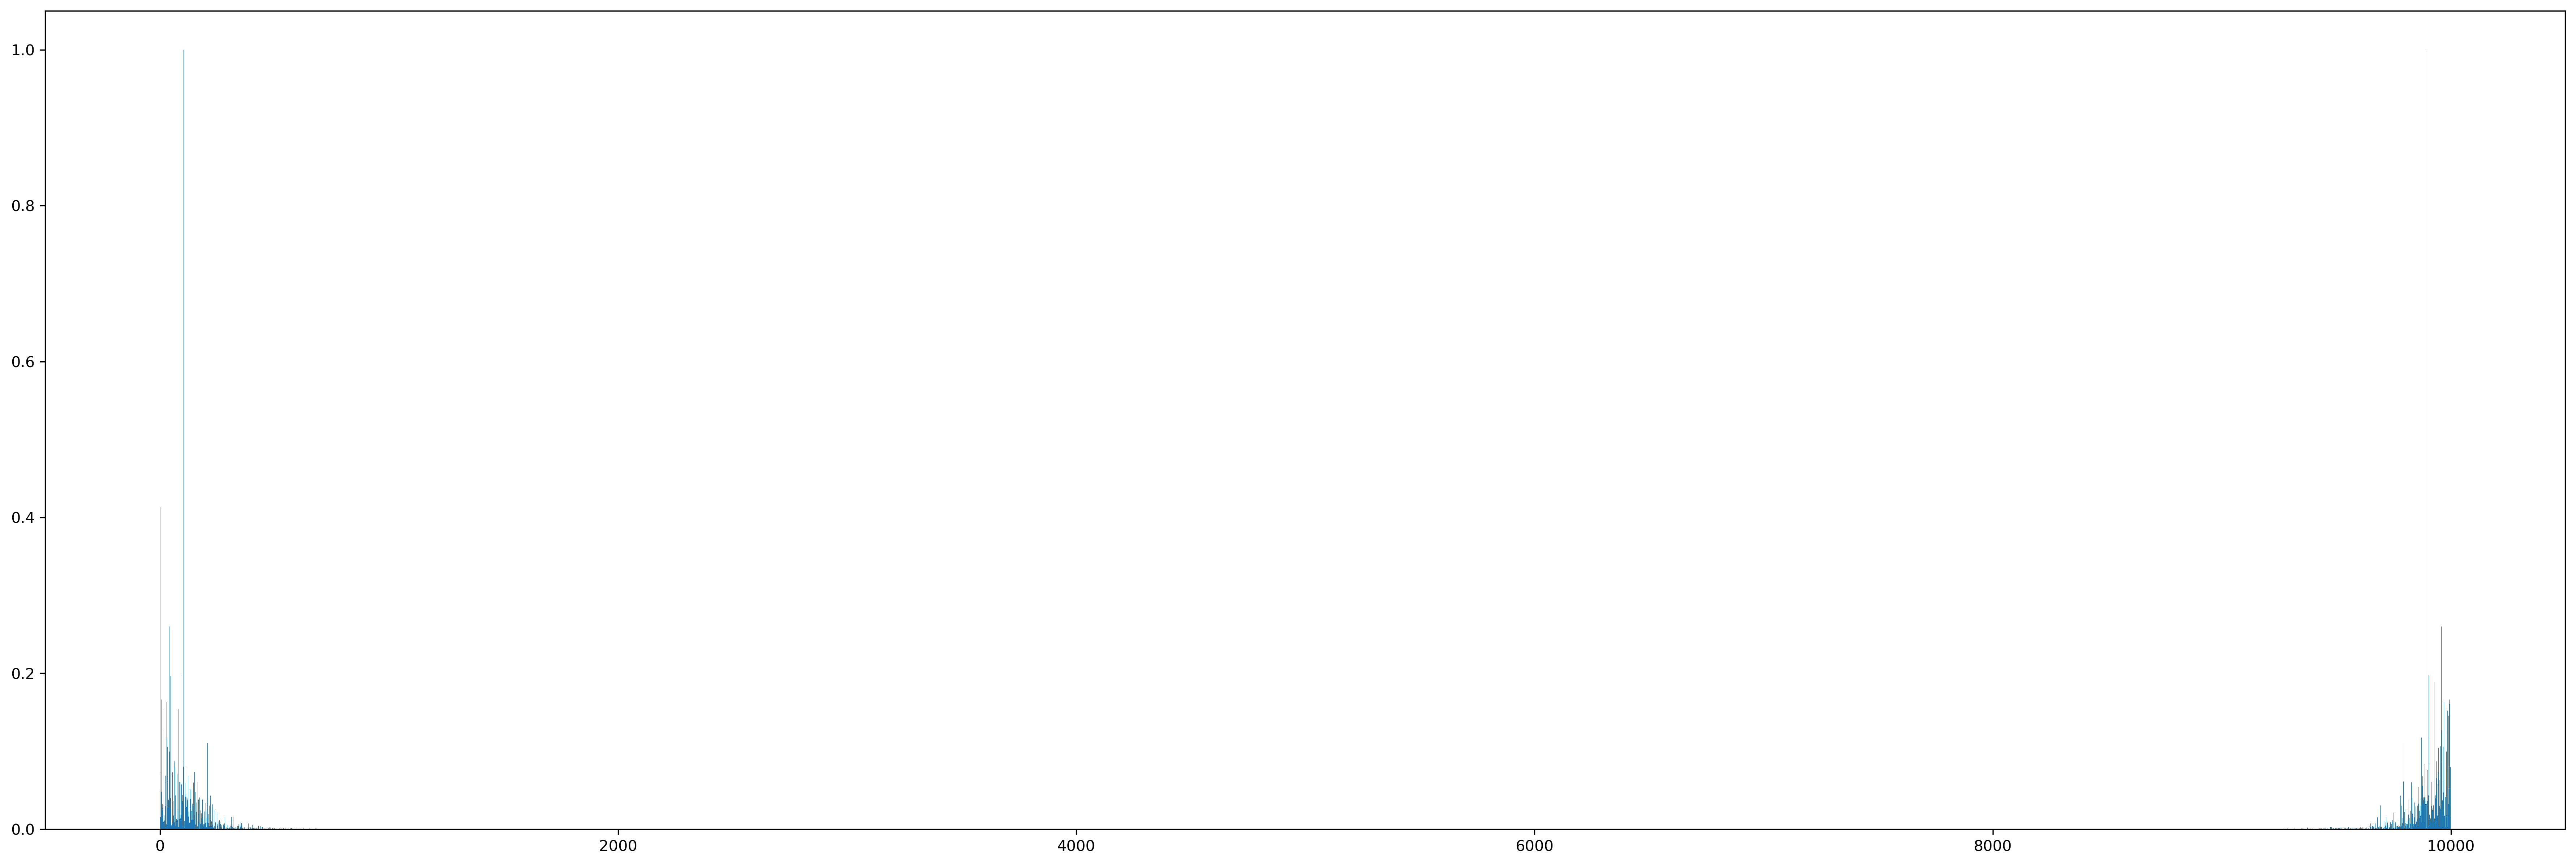

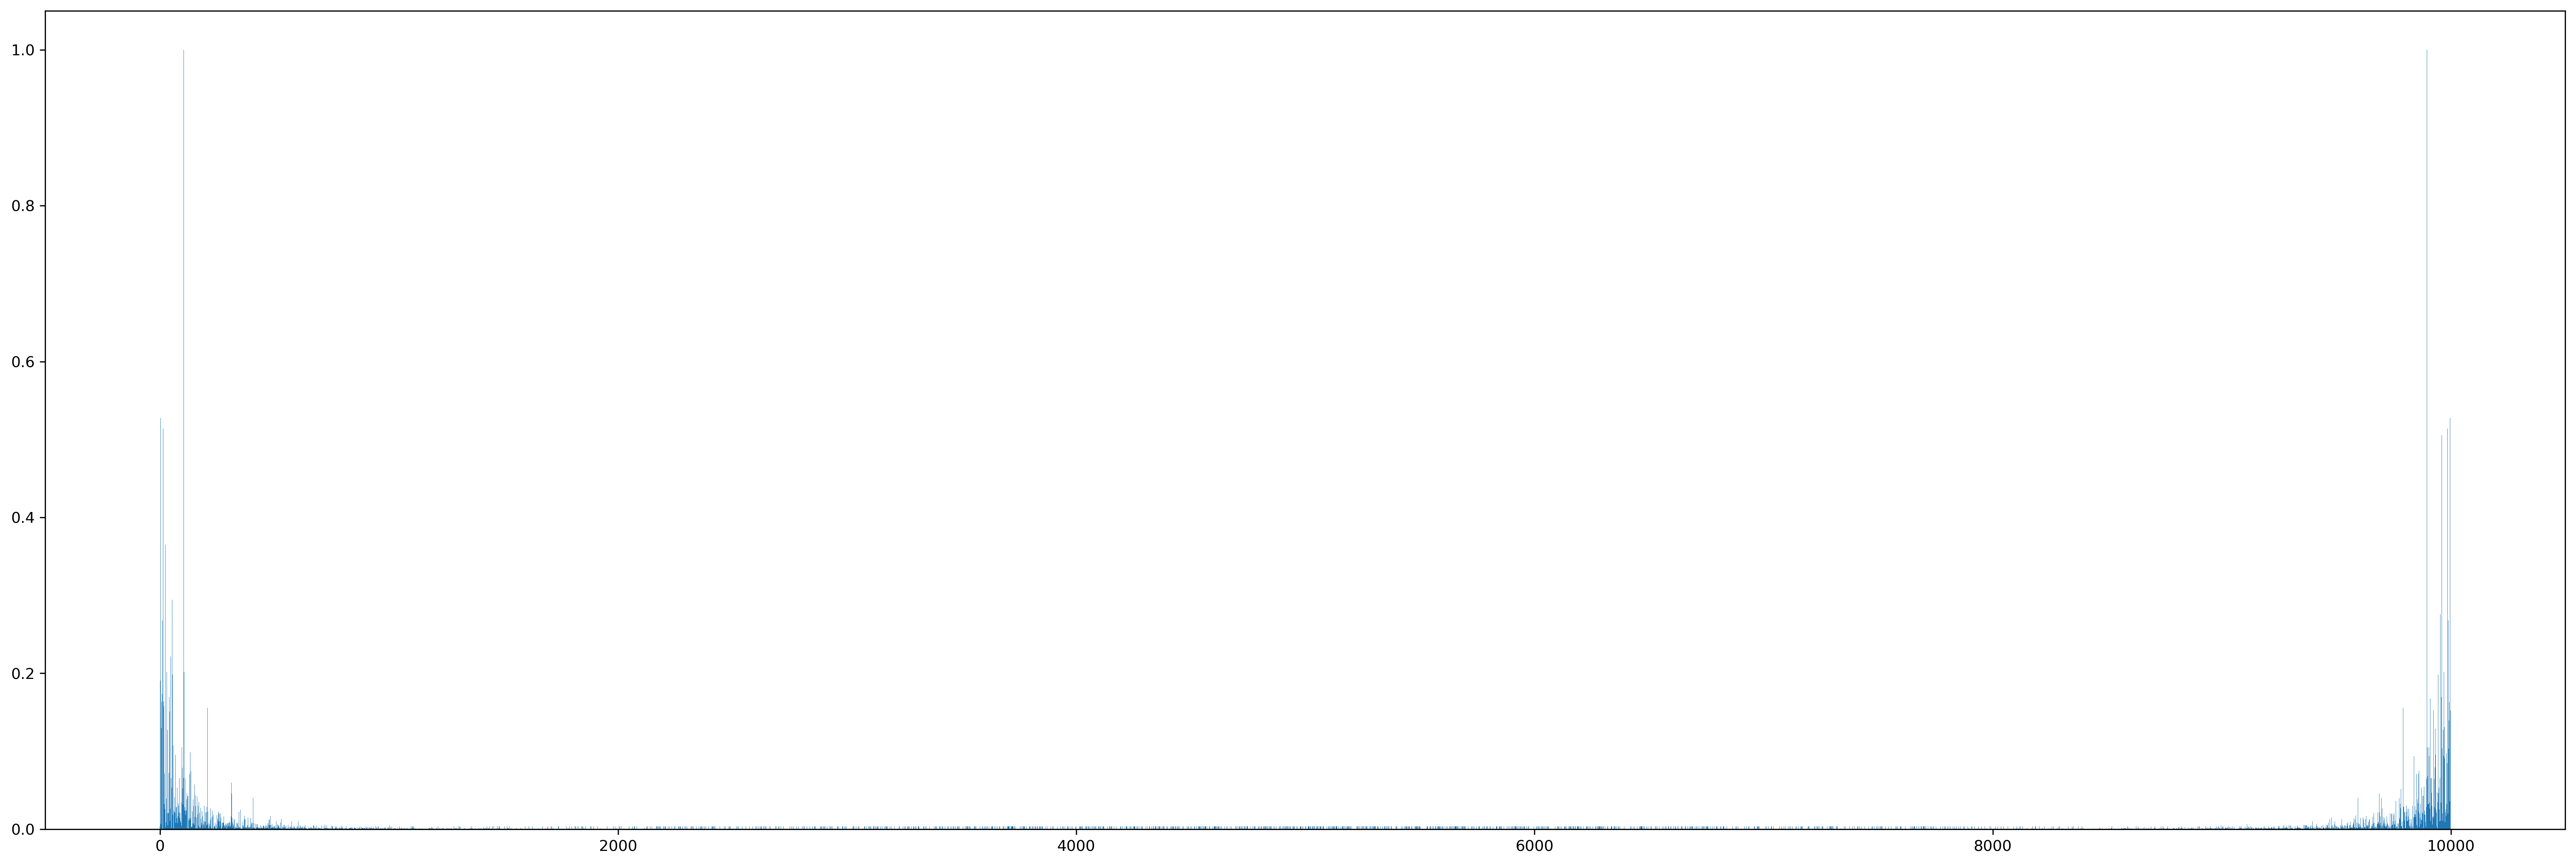

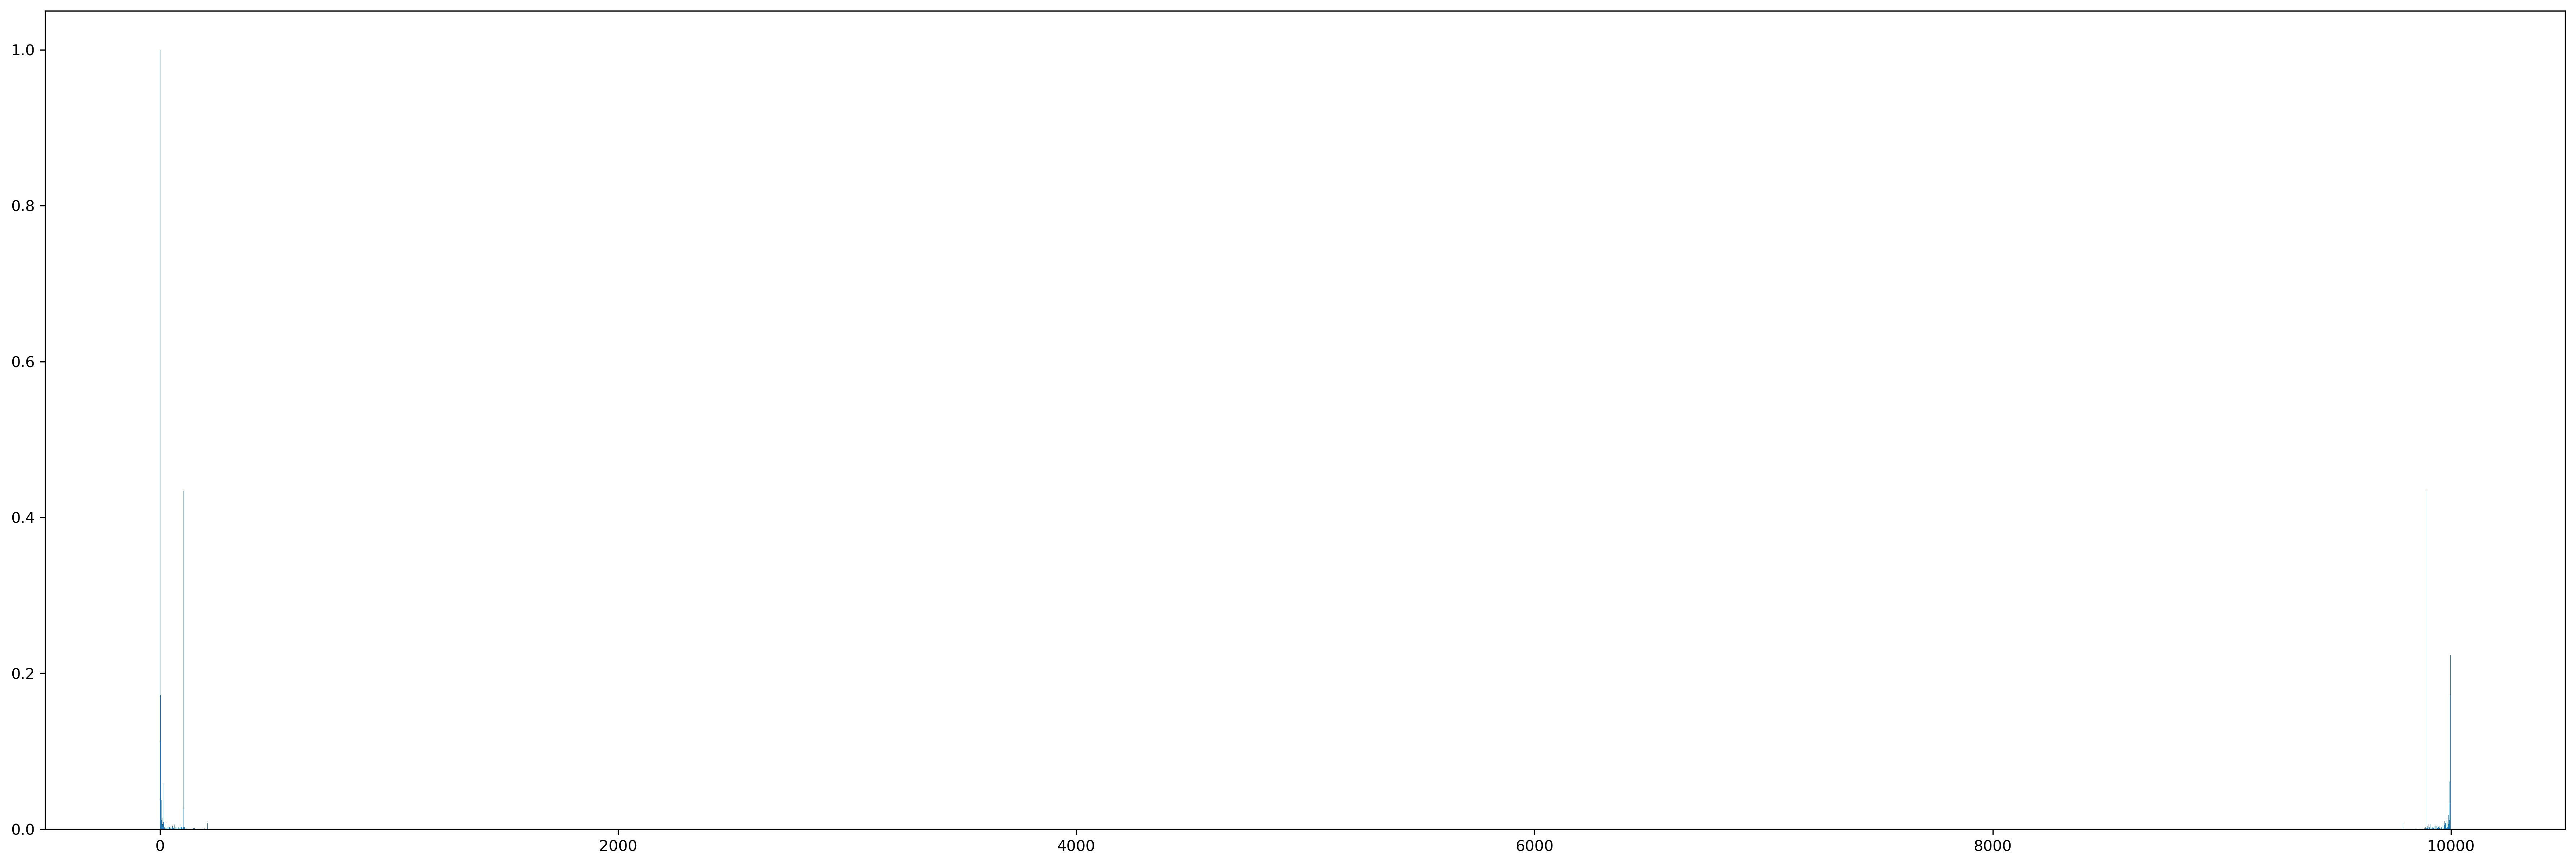

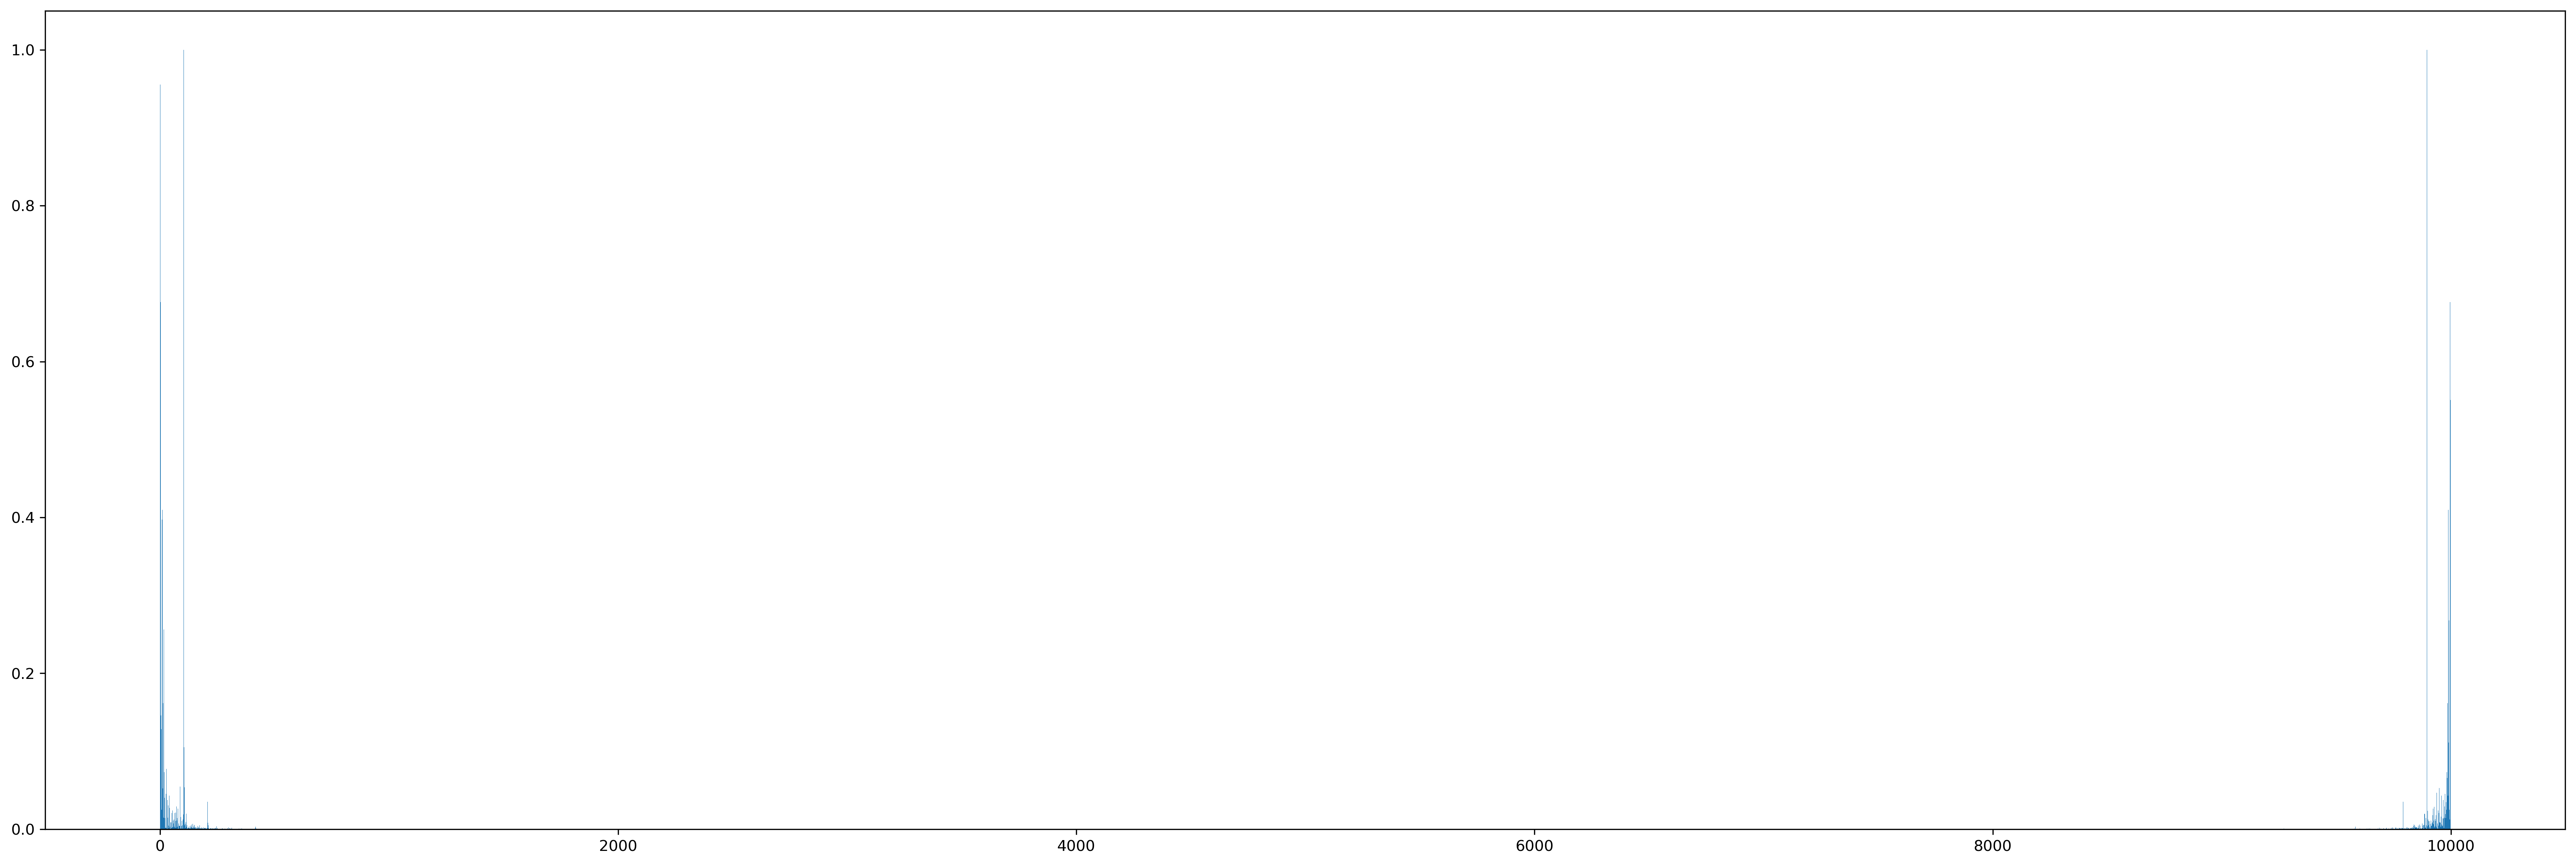

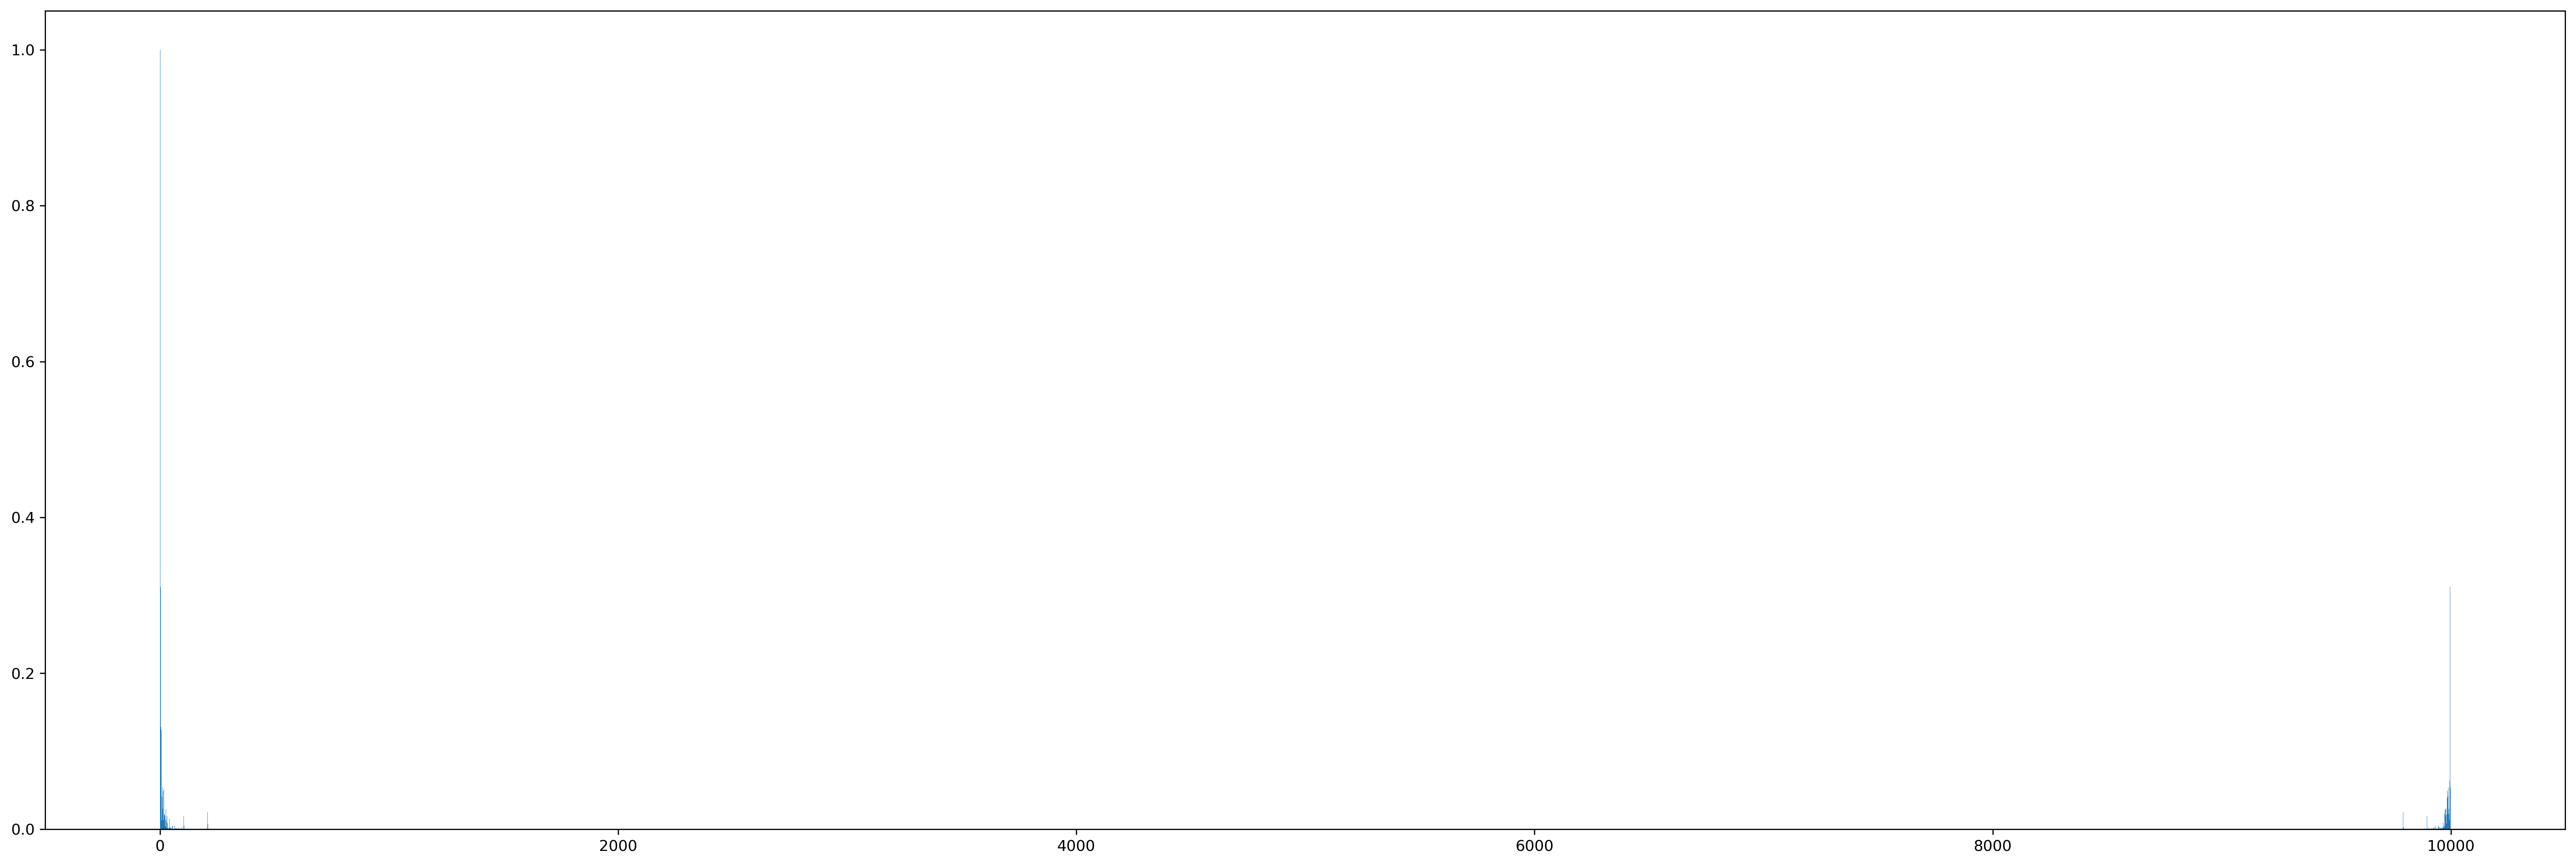

In [76]:
getsfgps(cc1,'第一列sfgps10000')
getsfgps(cc2,'第二列sfgps10000')
getsfgps(cc3,'第三列sfgps10000')
getsfgps(cc4,'第四列sfgps10000')
getsfgps(cc5,'第五列sfgps10000')

In [74]:
def getgraph(x,name,hh):
    ax,ay=get_AFAGPS(x,h=hh)
    max_ay = max(ay)
    ay = [y / max_ay for y in ay]
    plt.figure(figsize=(20,10),dpi=300)
    plt.plot(ax,ay)
    plt.savefig("C:\\Users\\Lenovo\\Desktop\\气象水文\\afagps功率谱new\\"+name+"10000afagps.png")

In [18]:
ax,ay=get_AFAGPS(c1,h=0.2)

In [22]:
np.min(ay)

9.693391940728254e-06

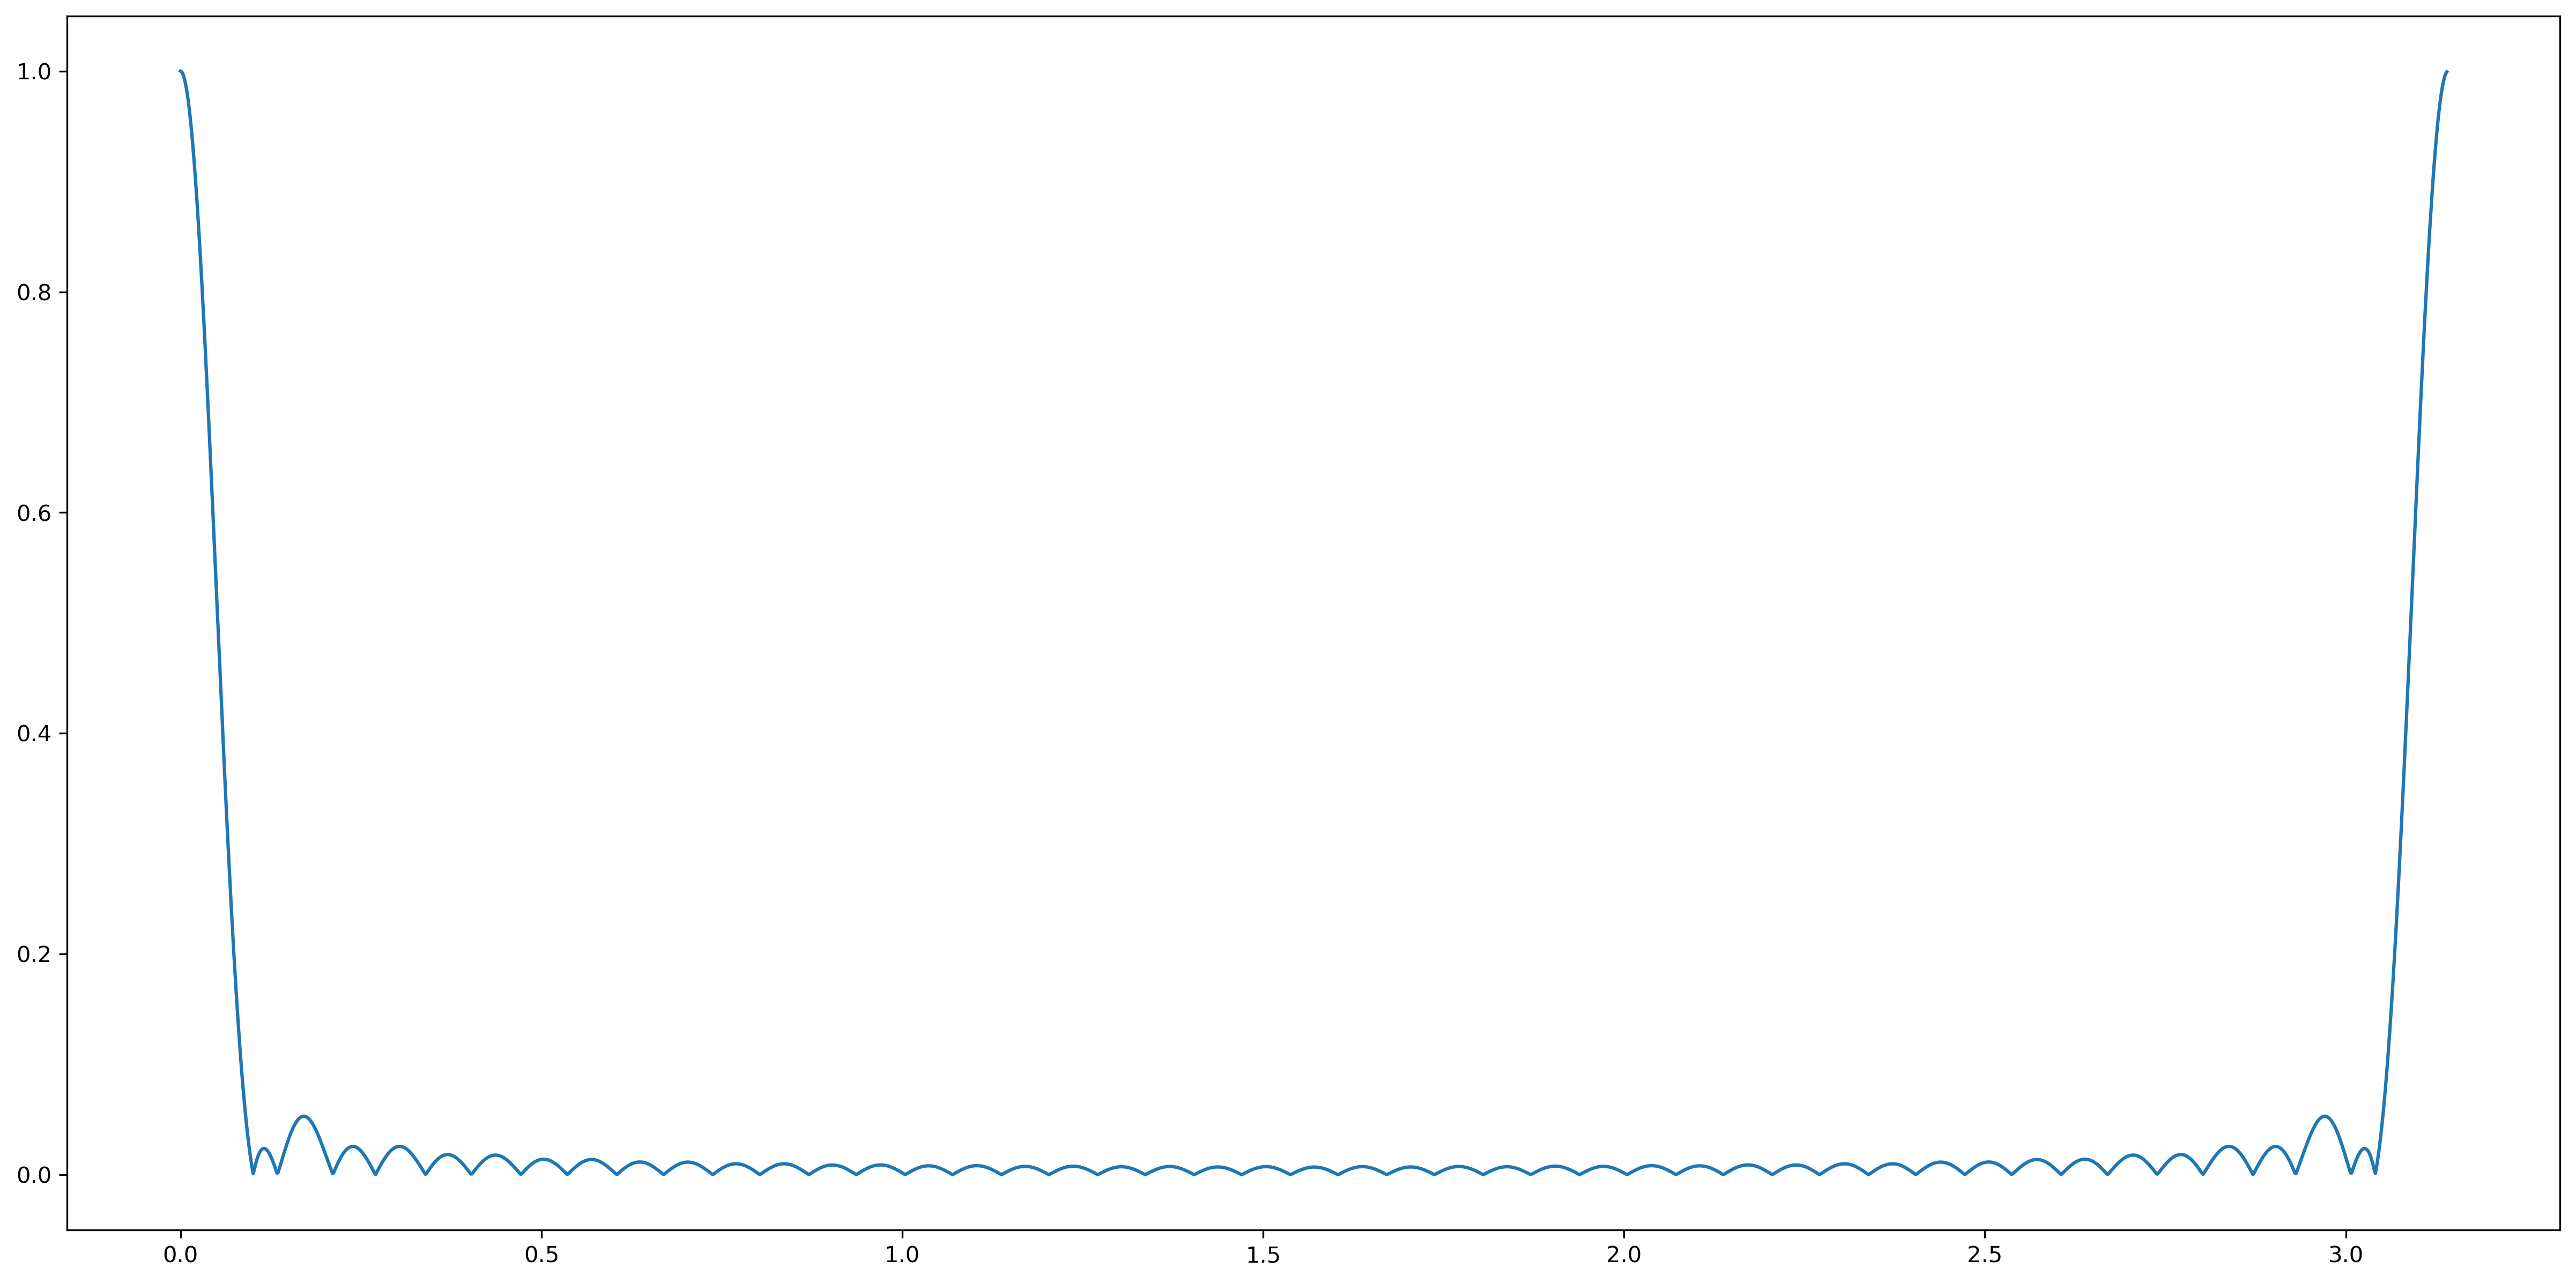

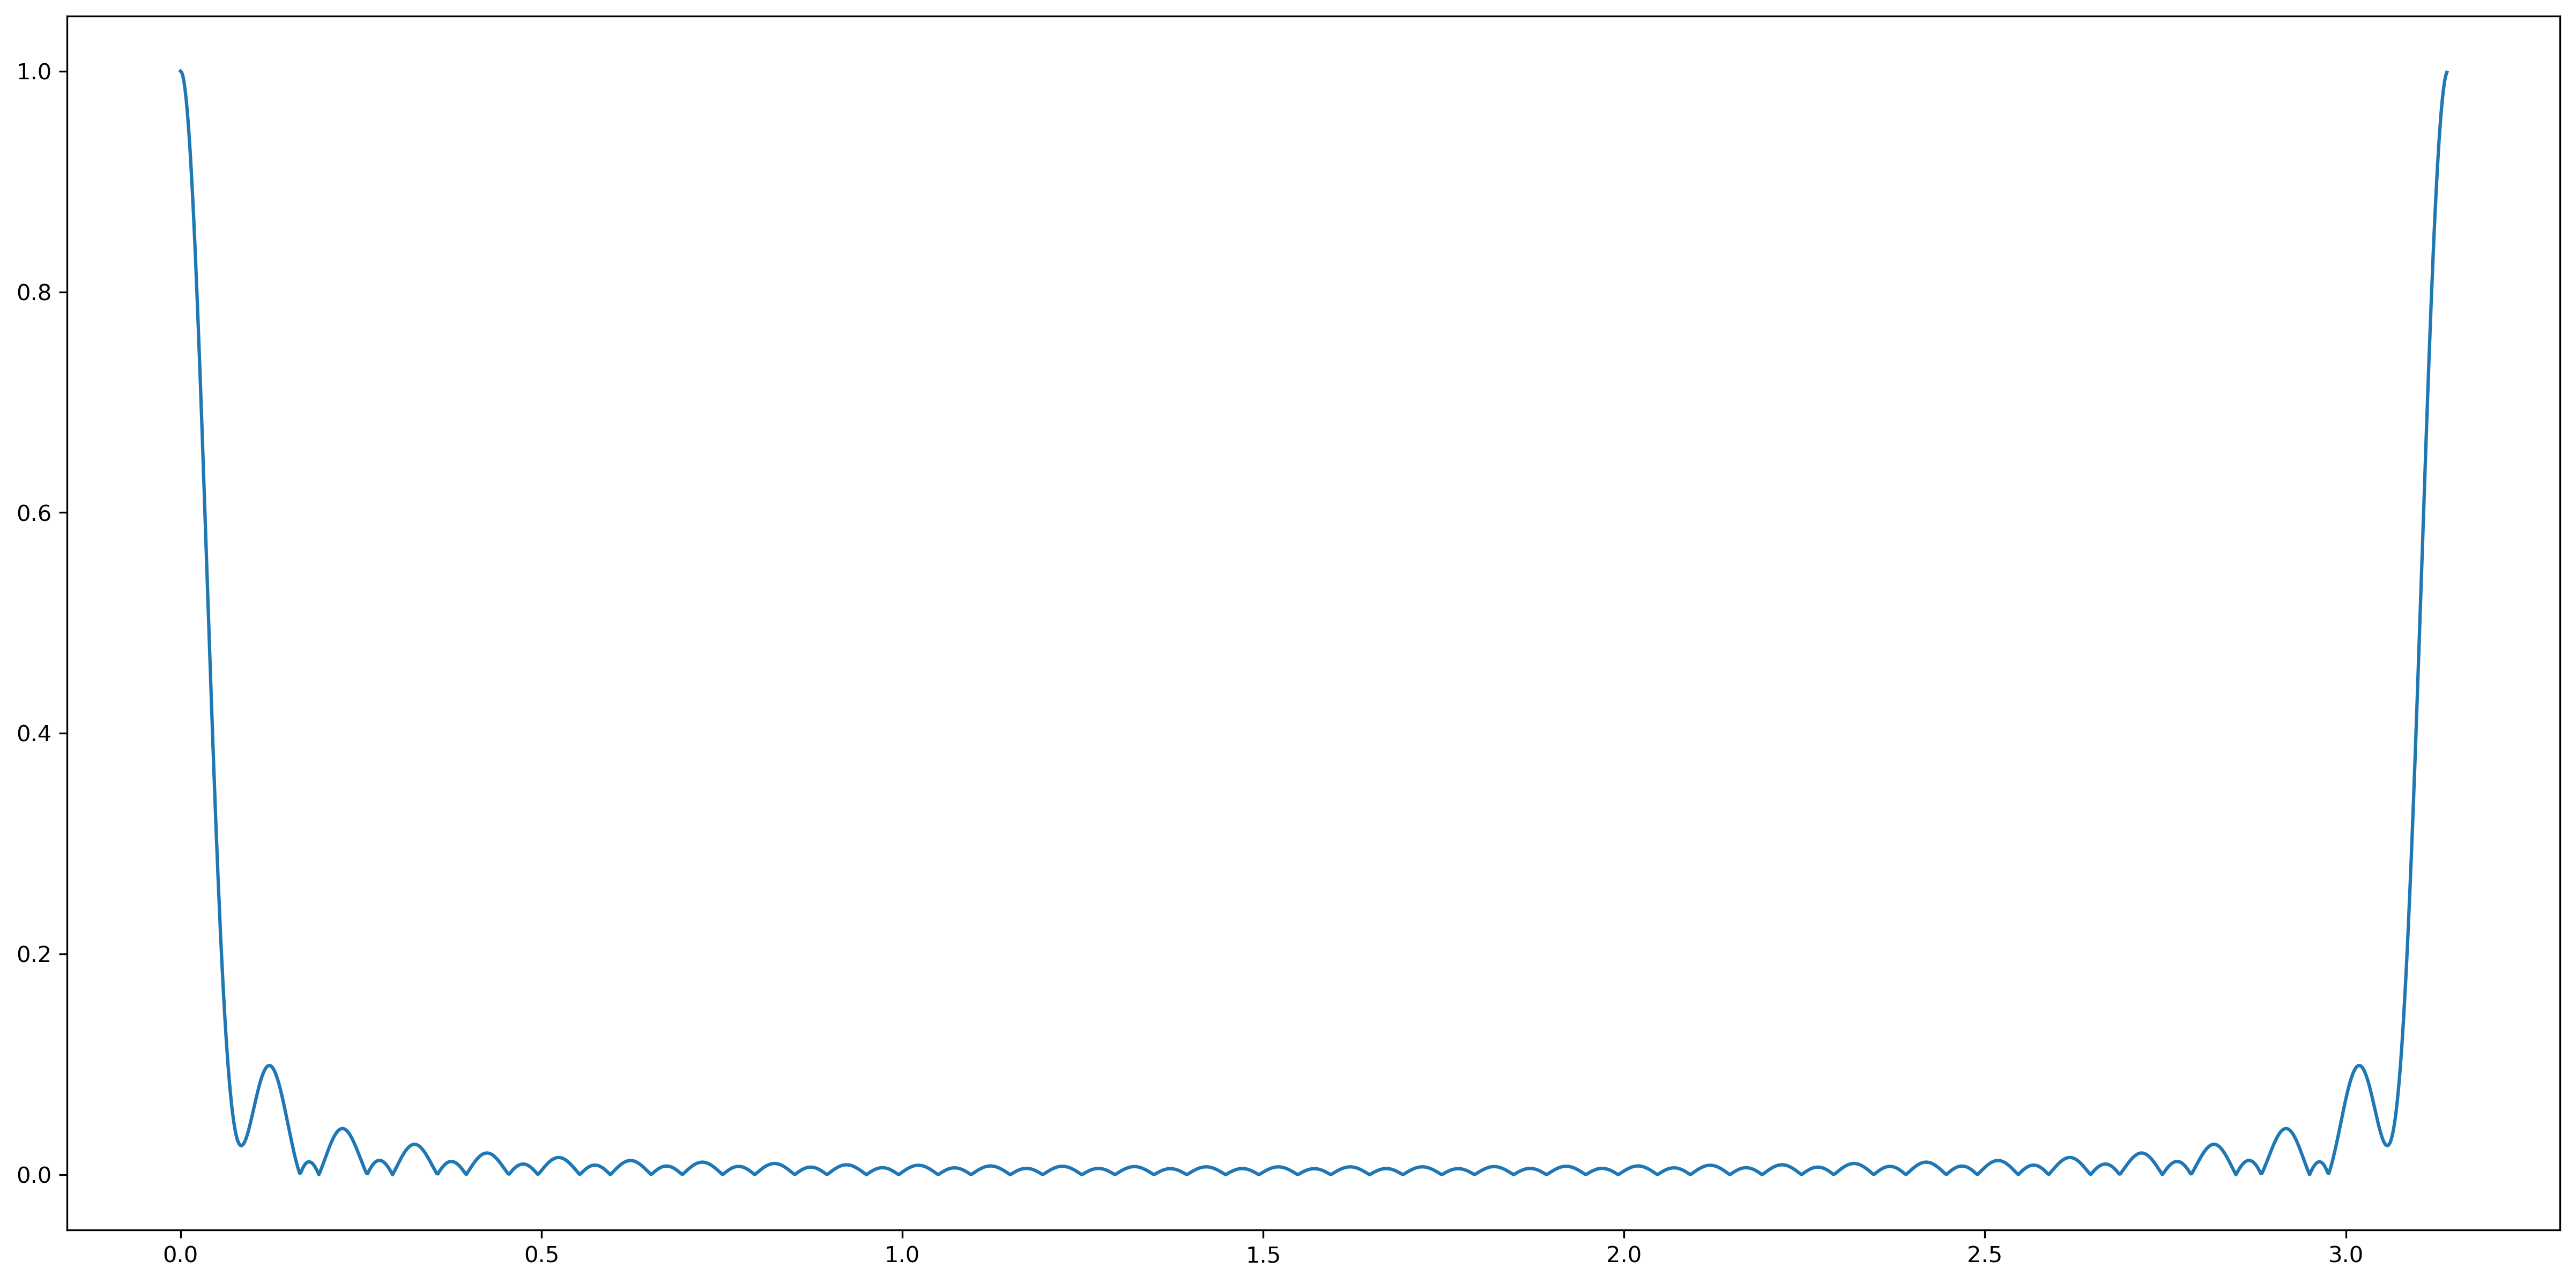

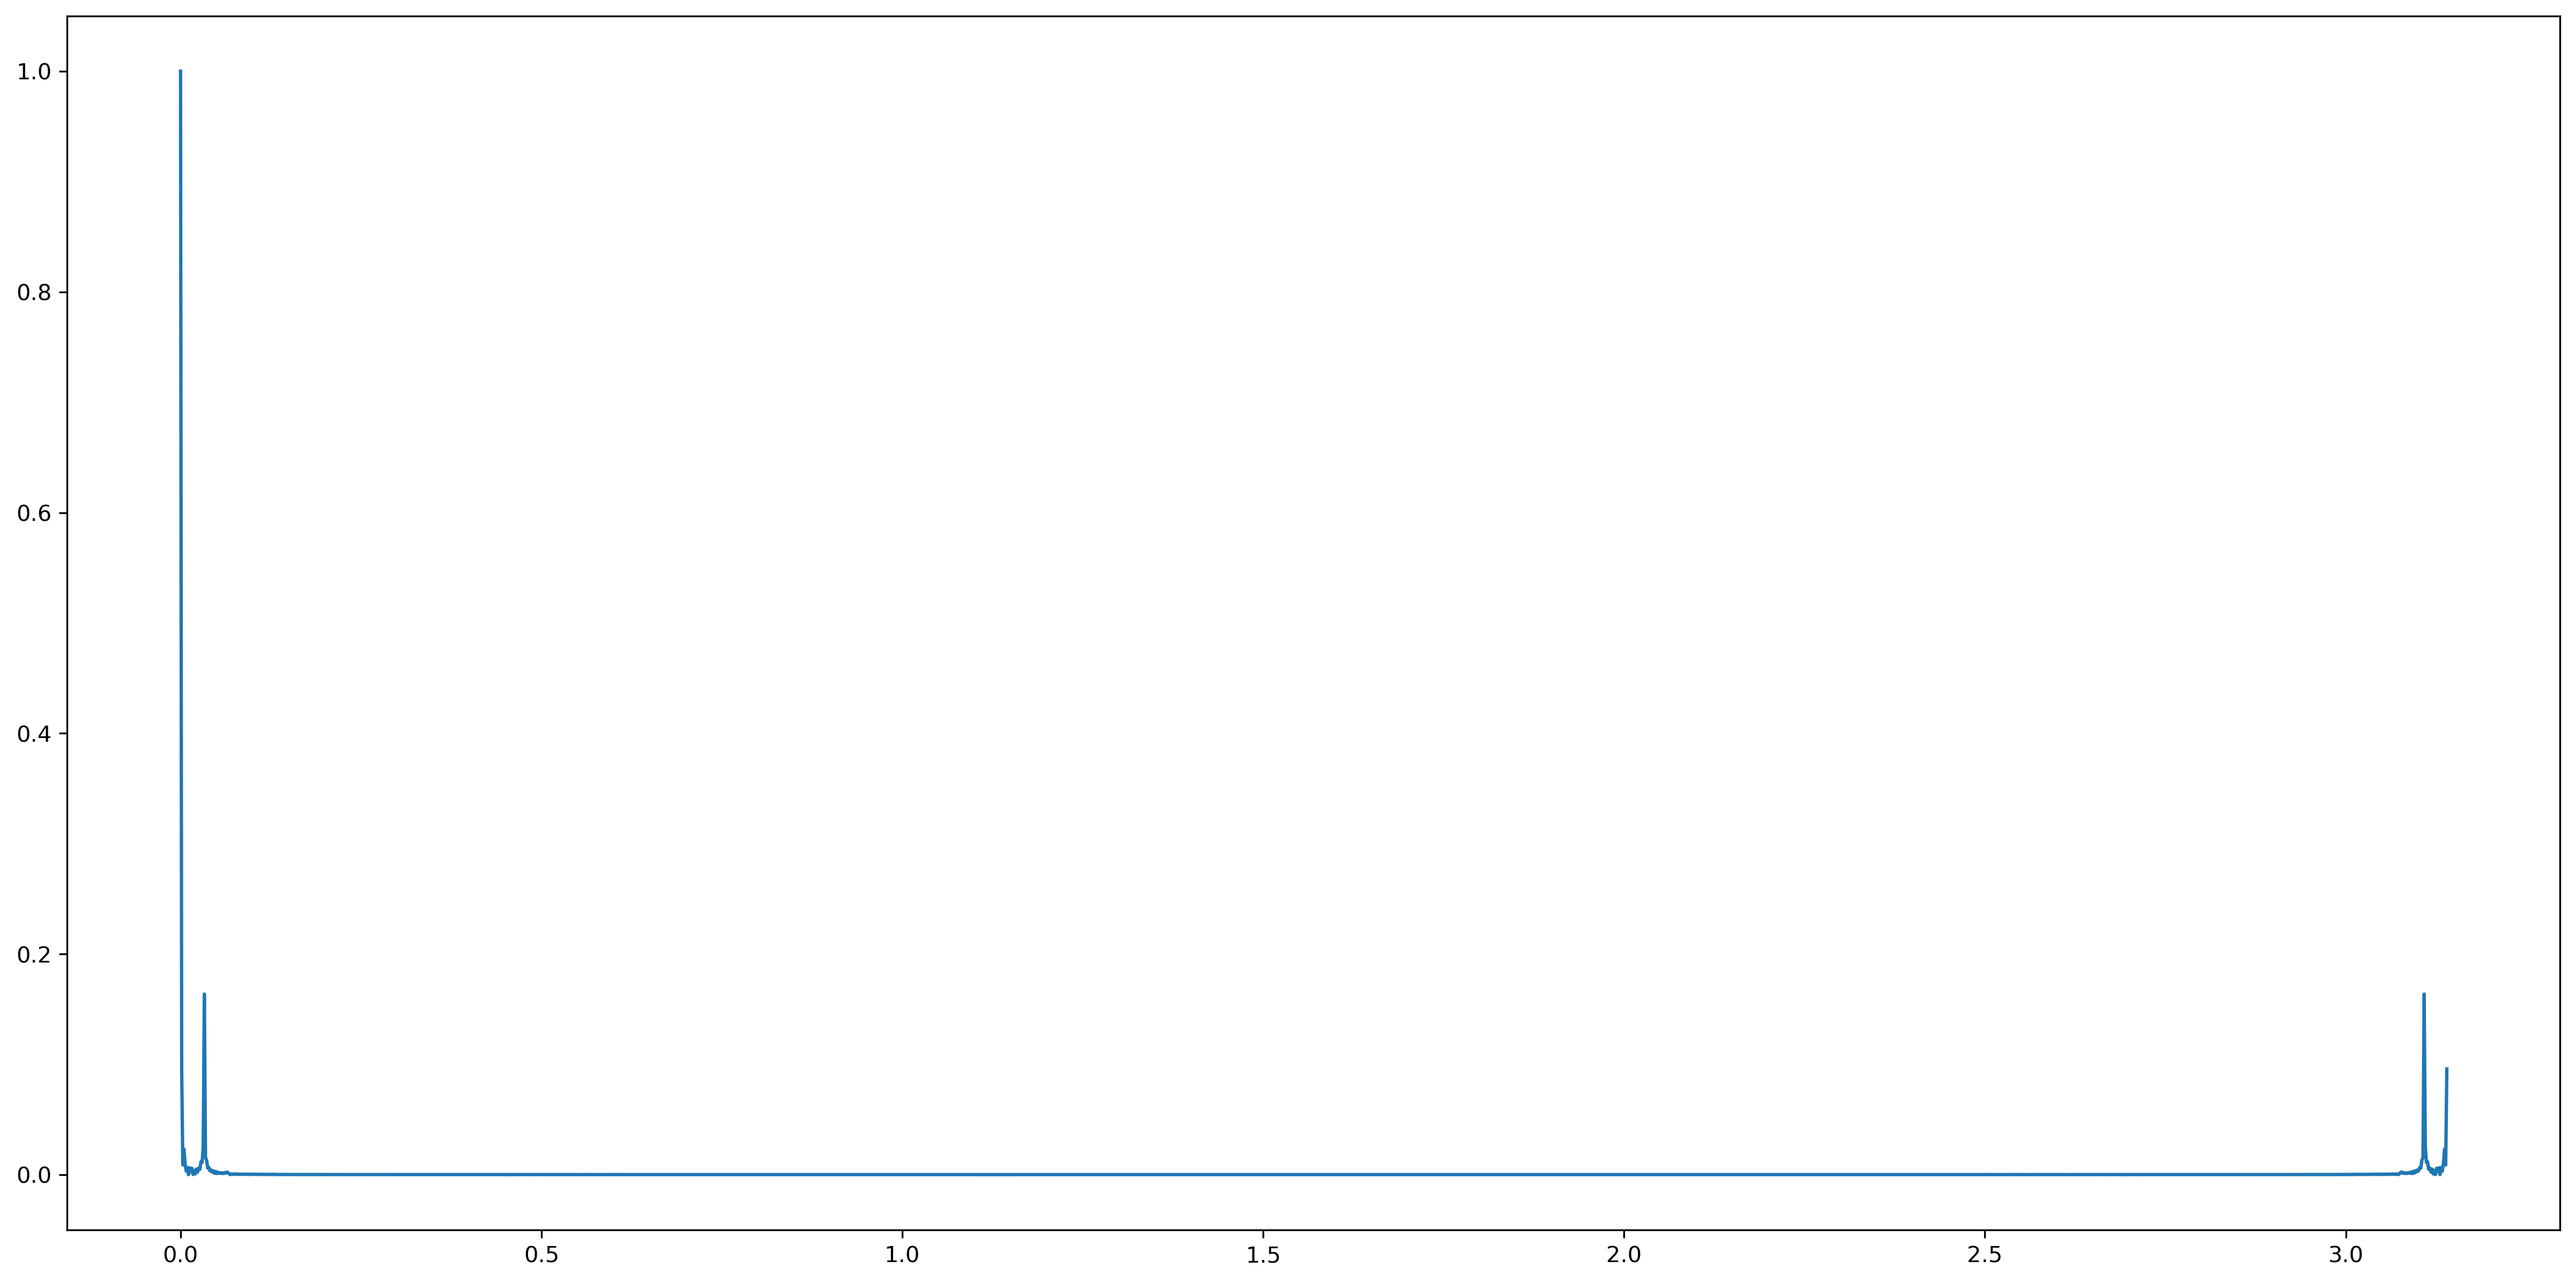

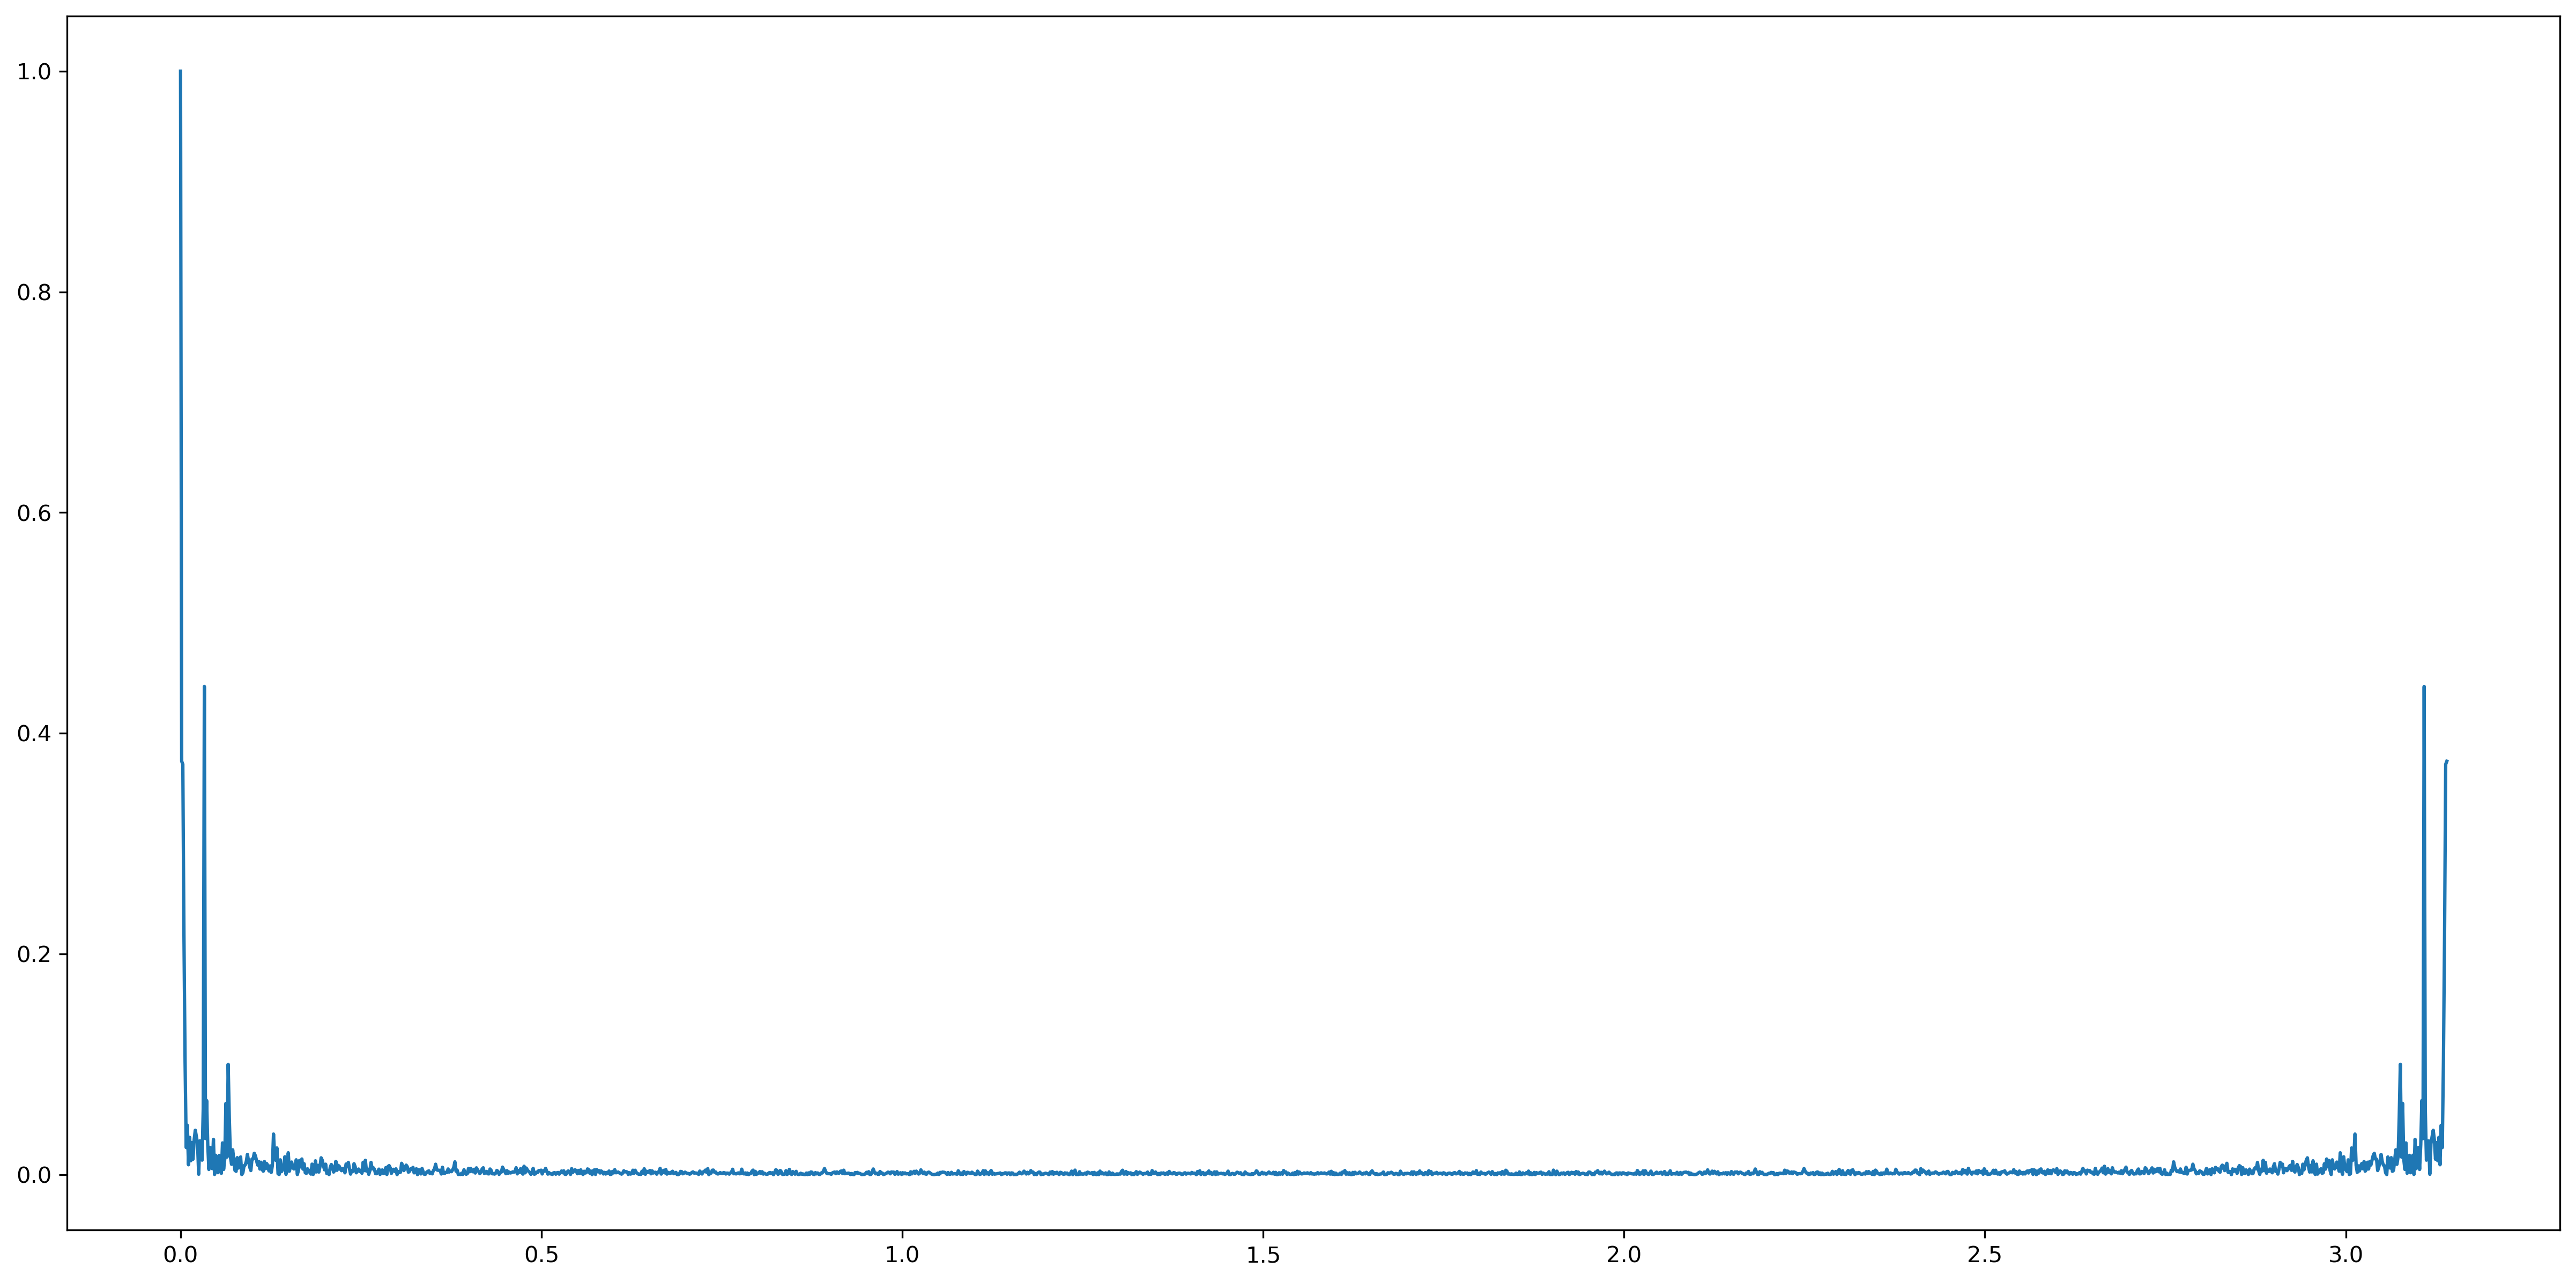

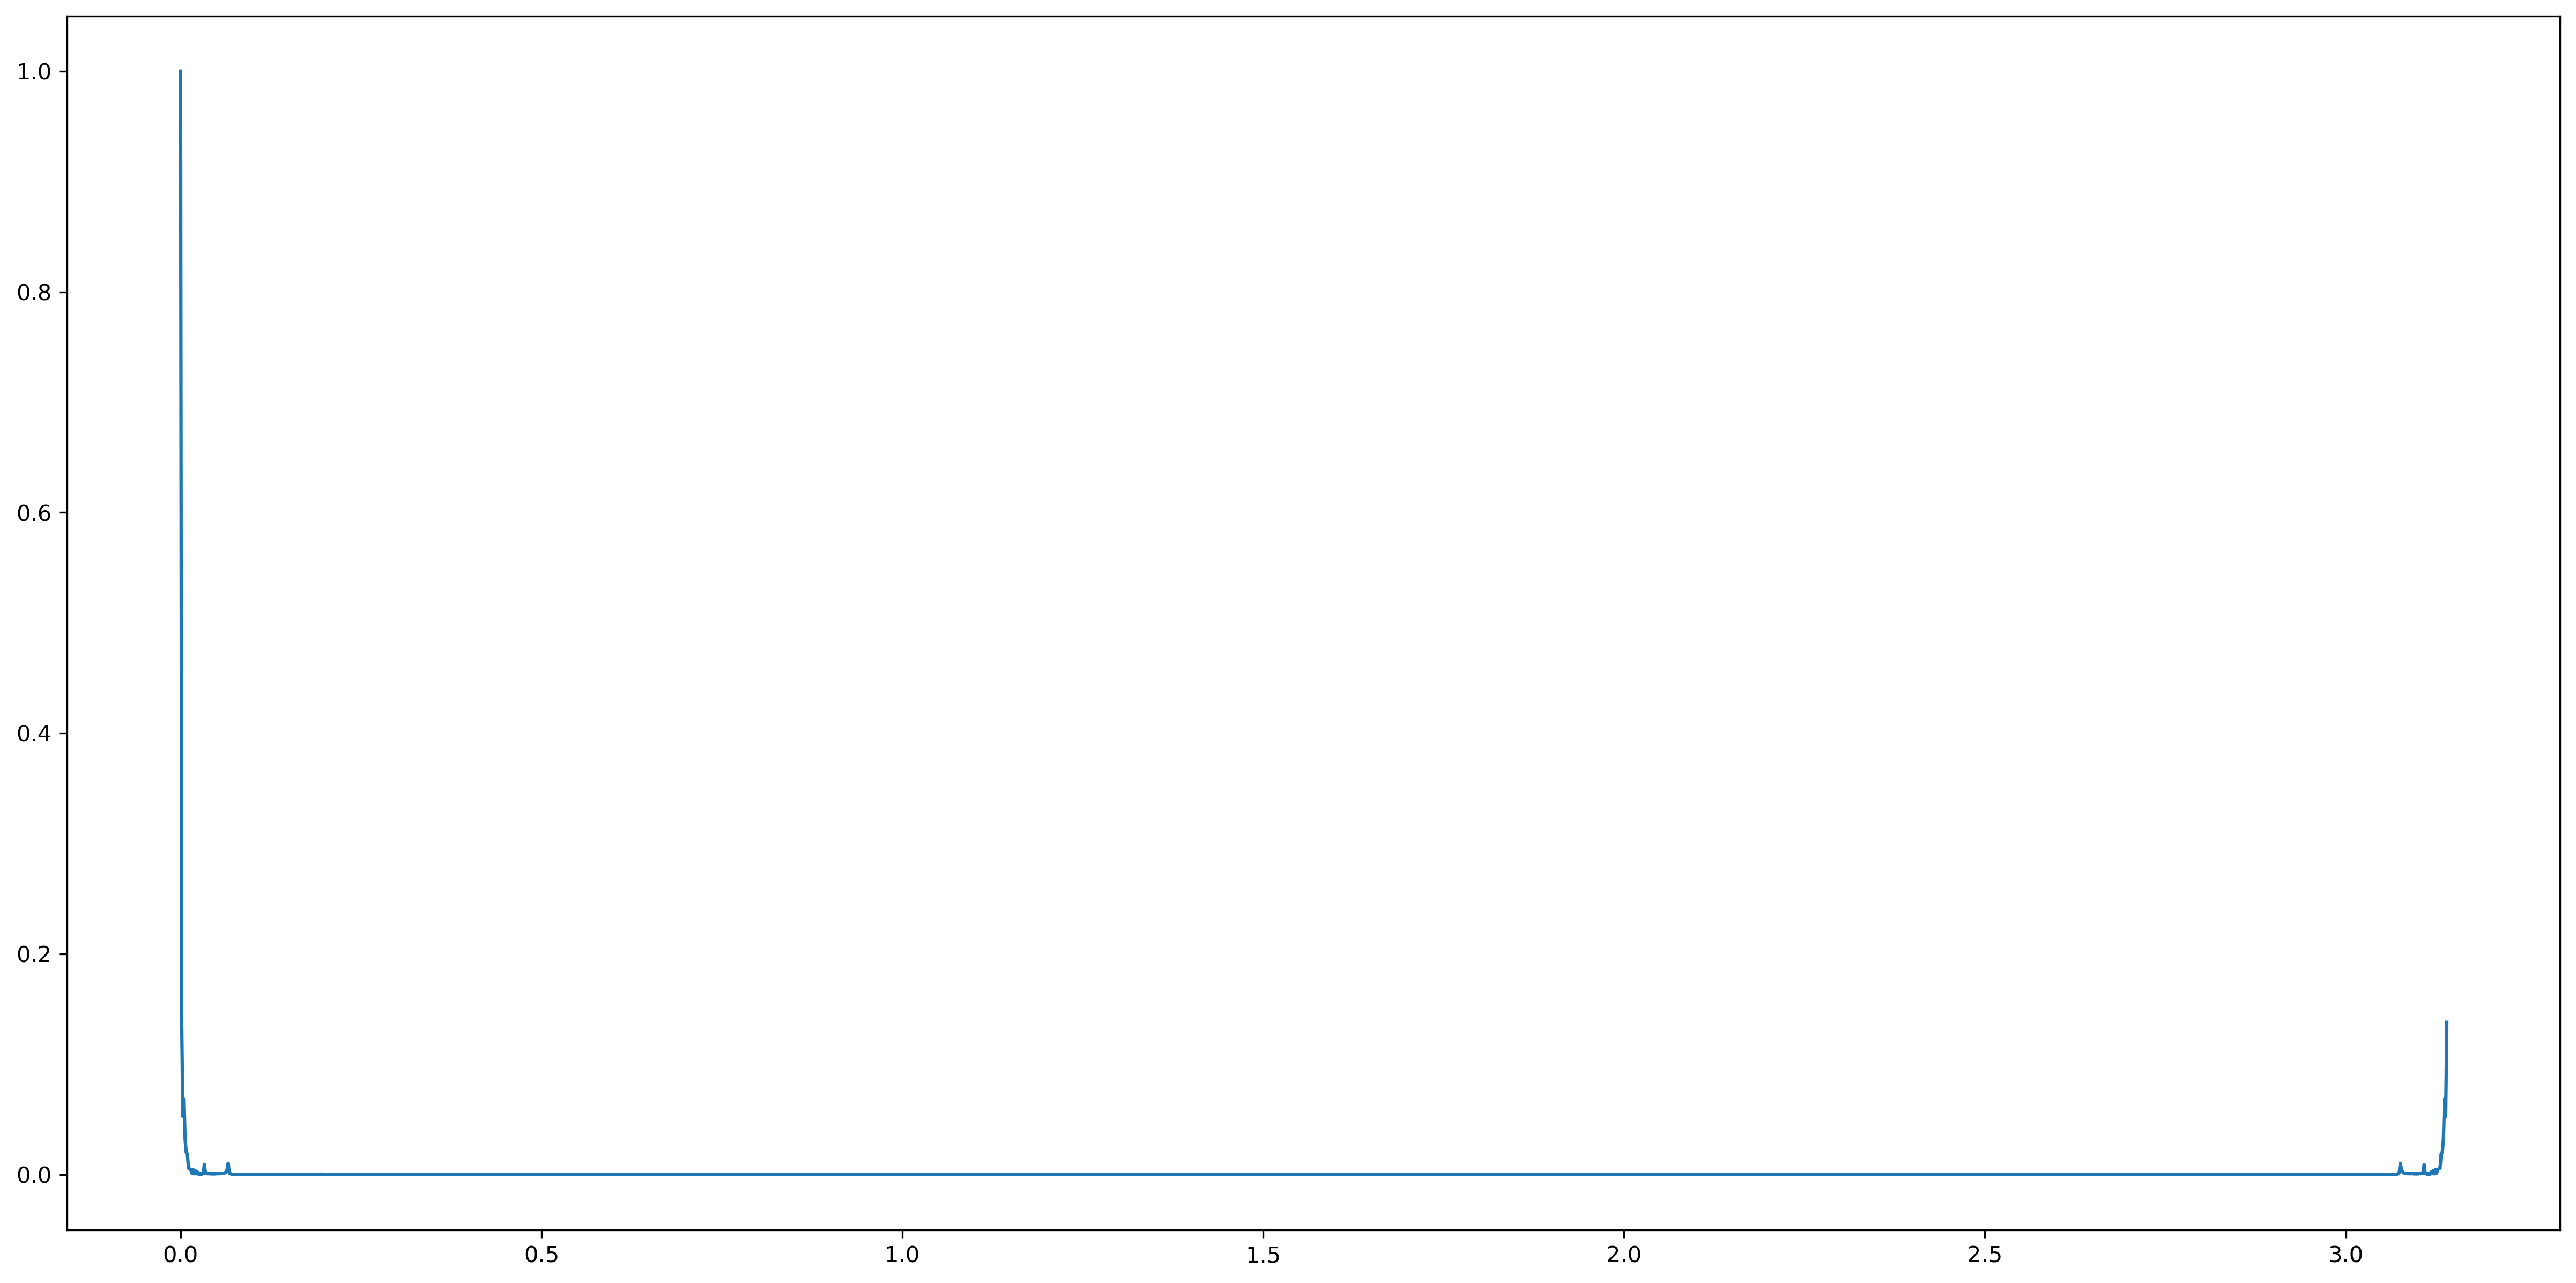

In [75]:
getgraph(c1,'第一列',0.2)
getgraph(c2,'第二列',0.2)
getgraph(c3,'第三列',0.2)
getgraph(c4,'第四列',0.2)
getgraph(c5,'第五列',0.2)

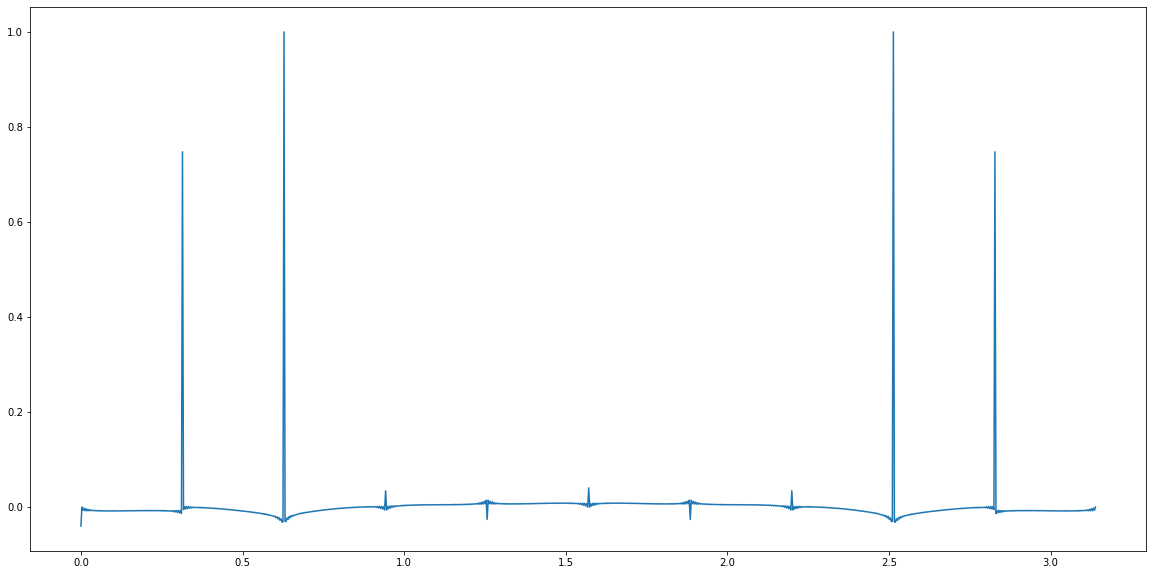

In [15]:
fs = 1000
t = np.arange(0, 1, 1/fs)
f0 = 100
f1 = 200
x = 100*np.cos(2*np.pi*f0*t) + 200*np.cos(2*np.pi*f1*t) + np.random.randn(t.size)
getgraph(x,'test')

In [13]:
c1

array([5.87, 6.19, 6.12, ..., 1.98, 2.06, 2.13], dtype=object)

In [15]:
ax,ay=get_AFAGPS(c2)
get_AFAGPS_graph('test',ax,ay,style='D')

([(0.012566370614359173, 0.006056421841641401, 4),
  (0.02199114857512855, 0.0019800704676395096, 7),
  (0.031415926535897934, 0.002914551222407568, 10),
  (0.04084070449666732, 0.0013333869190553691, 13),
  (0.05654866776461628, -0.00014380258314897632, 18),
  (0.06597344572538566, 0.0009212798108547731, 21),
  (0.08168140899333463, 0.00011895826331688714, 26),
  (0.0879645943005142, -4.00740684406095e-05, 28),
  (0.09738937226128358, 0.00041731294581439456, 31),
  (0.10681415022205297, -0.00014939104685583946, 34),
  (0.11623892818282235, -0.00013305802427744578, 37),
  (0.13194689145077132, -0.00021410328181279632, 42),
  (0.13823007675795088, -0.00026713042177818597, 44),
  (0.15079644737231007, -0.00014662481209062889, 48),
  (0.16336281798666927, -0.0002624770498345217, 52),
  (0.16964600329384882, -0.0002897877130318626, 54),
  (0.1790707812546182, -0.0004172632550536411, 57),
  (0.18535396656179778, -0.0003624517312623864, 59),
  (0.19792033717615698, -0.00038474279173921833, 6

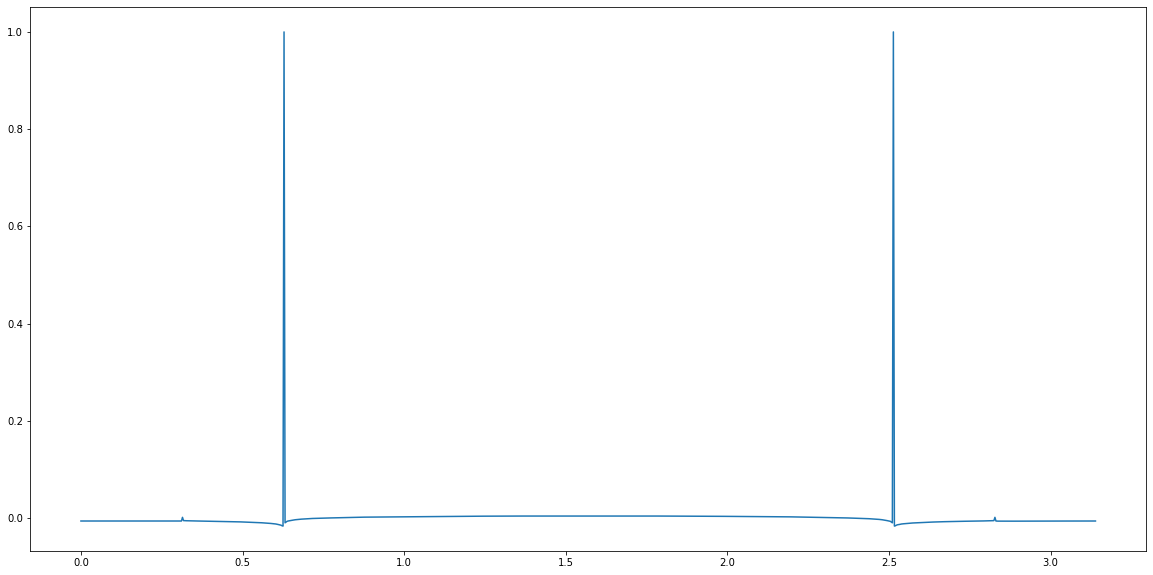

In [23]:
fs = 1000
t = np.arange(0, 1, 1/fs)
f0 = 100
f1 = 200
x = 10*np.cos(2*np.pi*f0*t) + 200*np.cos(2*np.pi*f1*t) + np.random.randn(t.size)
ax,ay=get_AFAGPS(x,h=0.3)
max_ay = max(ay)
ay = [y / max_ay for y in ay]
plt.figure(figsize=(20,10))
plt.plot(ax,ay)

In [24]:
max(ax)

3.138451060936203

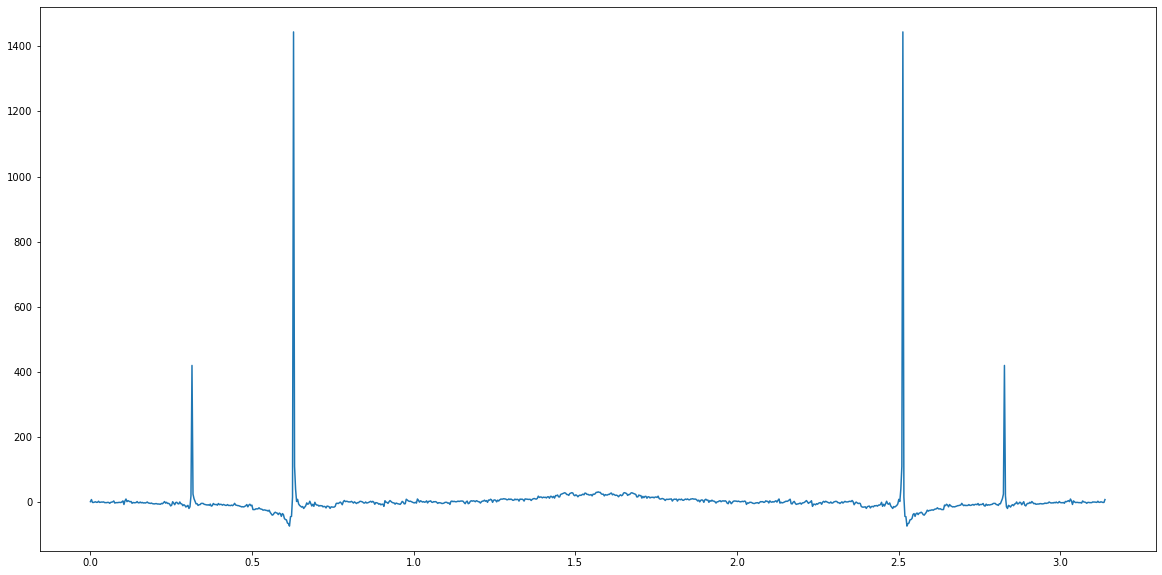

In [2]:
fs = 1000
#采样点数
num_fft = 1024;

"""
生成原始信号序列

在原始信号中加上噪声
np.random.randn(t.size)
"""
t = np.arange(0, 1, 1/fs)
f0 = 100
f1 = 200
x = np.cos(2*np.pi*f0*t) + 3*np.cos(2*np.pi*f1*t) + np.random.randn(t.size)
ax,ay=get_AFAGPS(x)
plt.figure(figsize=(20,10))
plt.plot(ax,ay)
#plt.savefig("C:\\Users\\Lenovo\\Desktop\\气象水文\\afagps计算功率谱\\col5.png")
#plt.show()

In [1]:
# coding:utf-8
'''
author:
    zhangzhaopeng
usage:
    AFAGPS算法计算功率谱
attention:
    get_extremum, get_AFAGPS_graph为辅助功能,
    与功率谱计算无关系.
'''
import numpy as np

def get_extremum(xx, yy, key=max, n=10):
    """
    获得至多n个极值, 如果key=max则获得极大值,
    如果key=min则获得极小值.

    Parameters
    ----------
    xx: list
        x axis data
    yy: list
        y axis data
    key: func
        default: max
        key for  extremum.
    n: int
        default: 10
        at most n extremum.

    Returns
    -------
    a list of at most n numbers.
    """
    if n == 0:
        return [()]
    data = []
    for x, y, idx in zip(xx, yy, range(len(xx))):
        if y != 0:
            data.append((x, y, idx))
    extremums = []
    cutoff = int(len(data) * 1.0 / n)
    for i in range(n):
        start = i * cutoff
        end = (1 + i) * cutoff
        x, y, idx = key(data[start:end], key=lambda t: t[1])
        if idx + 1 < len(yy):
            if key(yy[idx], yy[idx + 1], yy[idx - 1]) == yy[idx]:
                extremums.append((x, y, idx))
        else:
            extremums.append((x, y, idx))
    return extremums



In [28]:


def get_AFAGPS_graph(picName, x, y=None, h=0.2, style=None):
    """
    作功率谱图像

    Parameters
    ----------
    picName: str
        default: None
        图像名称
    x,y:
        若y为None，则计算列表x的功率谱结果并作图;
        否则，直接以x,y的值作图
    h:
        指定AFAGPS算法中过滤系数
    style:
        如果为'D'则作竖线图

    Returns
    -------
    exs: list
        极值对.
    """
    global yy
    if y == None:
        xx, yy = get_AFAGPS(x,tag='D', h)
    else:
        xx, yy = x, y
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D
    max_yy = max(yy)
    yy = [y / max_yy for y in yy]
    fig = plt.figure(figsize=(10, 10), dpi=300)
    plt.plot(xx, yy)
    ax = fig.add_subplot(111)
    exs = []
    for i in range(1, len(xx) - 1):
        if yy[i] > yy[i-1] and yy[i] > yy[i+1]:
            exs.append((xx[i], yy[i], i))
            if style == 'D':
                ax.add_line(Line2D((xx[i], xx[i]), (0, yy[i]), color='red'))
    if style != 'D':
        ax.scatter(xx, yy, linewidths=0.01)

    plt.xlim(0, 2 * np.pi)
    plt.ylim(0, 1.1)
    plt.xticks((0, np.pi / 2, np.pi, 3 * np.pi / 2, 2 * np.pi),
               (r"$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{4}$", r"$2\pi$"))
    plt.savefig("C:\\Users\\Lenovo\\Desktop\\气象水文\\afagps计算功率谱\\"+picName+".png")
    plt.close()
    return exs, max_yy




SyntaxError: positional argument follows keyword argument (Temp/ipykernel_18740/1558822899.py, line 25)

In [3]:
def listConvolve(x, y):
    """
    calculate linear convolution of two lists.

    Attention
    ---------
        len(x)=m, len(y)=n, m<=n
        return n length list: circular convolution of x and y
    """
    ########## old #################
    #result = np.convolve(x, y)[len(x)-1:len(y)]
    ########## new #################
    x.extend([0] * (len(y) - len(x)))
    result = np.fft.ifft(np.fft.fft(x) * np.fft.fft(y)).real
    return result




In [30]:
def get_AFAGPS(X, tag='D', h=0.2):
    '''
    Parameters
    ----------
    X: list
        需要计算功率谱的数据
    tag: str
    default: D
        C: continuous Fourier Transform
        D: Discrete Fourier Transfrom
    h: float
        指定AFAGPS算法中过滤系数

    Examples
    --------
    ref to test.py
    '''
    global yy
    X, N = [float(i) for i in X], len(X)
    # normalized
    mean, std = np.mean(X), np.std(X)
   # X = [(i - mean) / std for i in X]
    # reverse X
    X_reverse = X[::-1]
    # add zeros
    X_reverse.extend([0] * N)
    X=X_reverse[::-1]
	
    # circular convolution, the same as matlab function "cconv"
    Rn = listConvolve(X, X_reverse)
    Rn = [1.0 / (N-i) * Rn[i] for i in range(1000)]   ######change1
    # filt
    for idx, i in enumerate(Rn):
        if abs(i / Rn[0]) <= h:
            Rn[idx] = 0
    # add zeros
    #Rn.extend(len(Rn) * [0])    ########change2

    plist = [2 * value.real - Rn[0] for value in np.fft.fft(Rn)]
    #m = max([abs(i) for i in plist])
    #plist = [abs(i) / m for i in plist]

    if tag == 'C':
        """CFT"""
        yy = [i + j for i,
              j in zip(plist[len(plist) // 2 + 1:], plist[:len(plist) // 2 + 1])]
    elif tag == 'D':
        """DFT"""
        yy = plist
    else:
        import sys
        print("Error!")
        exit
    xx = []
    for i in range(len(yy)):
        xx.append(i * np.pi / len(yy))
    return xx, yy



In [5]:
def get_abs2_ps(X):
    """
    only for DFT.
    """
    X, N = [float(i) for i in X], len(X)
    # normalized
    mean, std = np.mean(X), np.std(X)
    X = [(i - mean) / std for i in X]
    R = np.fft.fft(X)
    absR = [abs(r)**2 for r in R]
    m = np.mean(absR)
    for idx, r in enumerate(absR):
        if r < m:
            absR[idx] = 0.
    xx = []
    for i in range(len(absR)):
        xx.append(i * 2 * np.pi / len(absR))
    return xx, absR

In [7]:
from scipy.fftpack import fft,ifft
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

In [8]:
da=pd.read_csv(r'D:\e\南开光伏课题数据集及说明\NK2_GF\评测数据\气象数据\Station_1.csv')
da=np.array(da)
da
c1=da[0:1000,2]
c2=da[0:1000,3]
c3=da[0:1000,4]
c4=da[0:1000,5]
c5=da[0:1000,6]

In [10]:
c1

array([5.87, 6.19, 6.12, 6.05, 5.97, 5.89, 5.8, 5.7, 5.59, 5.46, 5.29,
       5.1, 4.9, 4.68, 4.46, 4.24, 4.03, 3.83, 3.65, 3.49, 3.36, 3.25,
       3.13, 3.02, 2.91, 2.81, 2.71, 2.62, 2.55, 2.48, 2.44, 2.41, 2.4,
       2.43, 2.51, 2.64, 2.8, 2.98, 3.17, 3.36, 3.54, 3.7, 3.83, 3.91,
       3.94, 3.94, 3.93, 3.91, 3.9, 3.87, 3.85, 3.82, 3.79, 3.76, 3.73,
       3.7, 3.67, 3.64, 3.6, 3.57, 3.53, 3.49, 3.45, 3.41, 3.37, 3.32,
       3.28, 3.23, 3.18, 3.13, 3.07, 3.01, 2.95, 2.88, 2.82, 2.75, 2.69,
       2.63, 2.58, 2.53, 2.5, 2.46, 2.43, 2.4, 2.37, 2.34, 2.31, 2.28,
       2.26, 2.24, 2.23, 2.22, 2.22, 2.23, 2.26, 2.3, 2.36, 2.73, 2.7,
       2.68, 2.67, 2.65, 2.64, 2.63, 2.63, 2.65, 2.69, 2.75, 2.82, 2.91,
       3.0, 3.1, 3.18, 3.26, 3.32, 3.36, 3.38, 3.36, 3.31, 3.24, 3.15,
       3.04, 2.94, 2.83, 2.72, 2.63, 2.56, 2.51, 2.5, 2.53, 2.64, 2.8,
       3.0, 3.23, 3.47, 3.72, 3.95, 4.15, 4.31, 4.41, 4.45, 4.45, 4.45,
       4.44, 4.43, 4.42, 4.41, 4.39, 4.38, 4.36, 4.35, 4.33, 4.32, 4.3

In [31]:
get_AFAGPS_graph('新第一列',c1)

Error!


NameError: name 'yy' is not defined

SystemExit: 1

In [8]:
x=np.linspace(0,1,10000)
y=2*np.cos(3*np.pi*x)+9*np.cos(10*np.pi*x)

In [14]:
y=noise+y

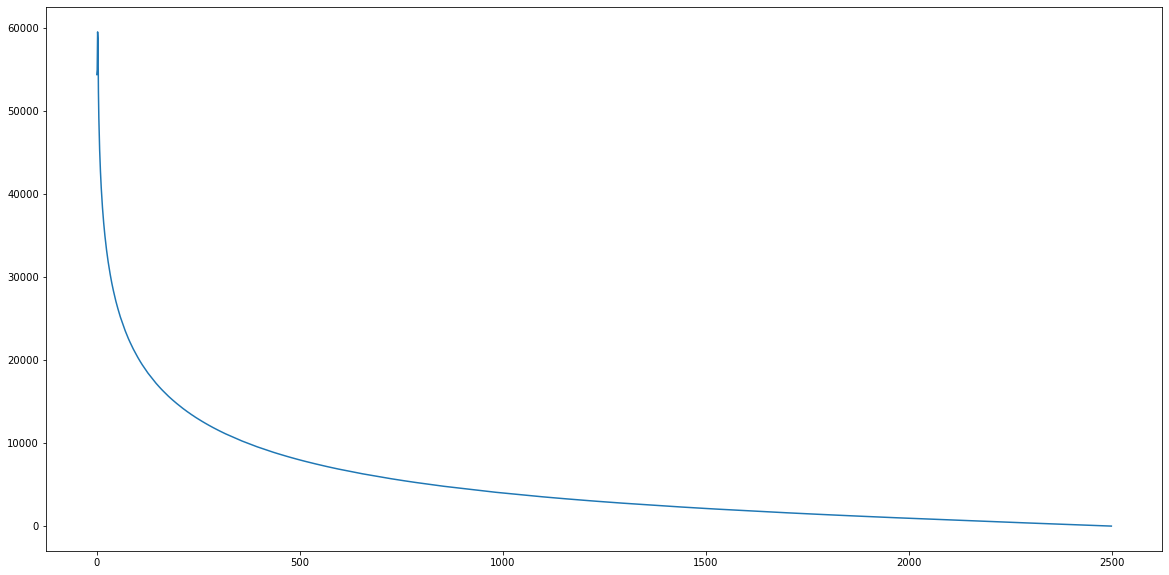

In [9]:
afagps(y,0.1,1)

In [5]:
def afagps(x,s,name):
    z=ifft(np.multiply(fft(x),fft(x[::-1])))
    r=list()
    k=len(x)/2
    for i in range(int(k)):
        r.append(z[i]/(k-i))
    rk=r/r[0]
    for i in range(len(rk)):
        if abs(rk[i])<=s:
            rk[i]=0
    ark=np.array(rk)
    rr=np.hstack((ark[::-1],np.delete(ark,[0])))
    a=fft(rr)
    p=list()
    for i in range(len(a)):
        p.append(a[i]*math.e**(1j*i*math.pi*len(x)/2/(2*(len(x)/2+1))))
    pp=list()
    for i in range(int(len(x)/4)):
        pp.append(abs(p[2*i]))
    plt.figure(figsize=(20,10))
    plt.plot(pp)
    #plt.savefig("C:\\Users\\Lenovo\\Desktop\\气象水文\\afagps计算功率谱\\"+name+".png")
    plt.show()

In [19]:
def gafagps(x,s,name):
    z=np.hstack((ifft(fft(x)),ifft(fft(x[::-1]))))
    r=list()
    for i in range(int(len(x)/2)):
        r.append(z[i]/(len(x)/2-i))
    rk=r/r[0]
    for i in range(len(rk)):
        if abs(rk[i])<=s:
            rk[i]=0
    ark=np.array(rk)
    rr=np.hstack((ark[::-1],np.delete(ark,[0])))
    a=fft(rr)
    p=list()
    for i in range(len(a)):
        p.append(a[i]*math.e**(1j*i*math.pi*len(x)/2/(2*len(x/2)+1)))
    pp=list()
    for i in range(int(len(x)/4)):
        pp.append(p[2*i])
    pp=np.array(pp)
    #pp=np.delete(pp,np.where(pp<0))
    plt.figure(figsize=(20,10))
    plt.plot(pp)
    #plt.savefig("C:\\Users\\Lenovo\\Desktop\\气象水文\\afagps计算功率谱\\"+name+".png")
    plt.show()

In [7]:
z=ifft(fft(c1)*fft(c1[::-1]))

In [8]:
print(z)

[15597.4408-1.81898940e-15j 15535.5944-5.83781912e-14j
 15448.2249+3.63797881e-15j 15339.0867-1.14710019e-13j
 15212.417 +3.52429197e-15j 15072.9116-7.63975549e-14j
 14925.049 -7.27595761e-15j 14772.9955-7.04858394e-15j
 14620.1727-7.27595761e-15j 14469.6348-5.81365225e-14j
 14323.5247+5.40744069e-14j 14183.4373-1.48274885e-13j
 14050.2714-3.62878135e-14j 13924.4413-7.09293792e-14j
 13806.0217+3.88935696e-14j 13694.7541+1.58911972e-14j
 13590.123 +3.63797881e-15j 13492.0971-8.36180867e-14j
 13401.0106+5.95711316e-14j 13317.2649-1.89263086e-13j
 13241.3025-1.45870464e-14j 13173.3508+9.06991234e-16j
 13113.5024-7.70923471e-14j 13061.767 -5.97432281e-14j
 13017.9128+1.45519152e-14j 12981.3821-5.10925227e-14j
 12951.5273+1.97696100e-14j 12927.4223-1.22978562e-13j
 12908.1053-1.45870464e-14j 12892.5883+6.09386485e-14j
 12879.8589-2.61606438e-14j 12868.9643+2.43627749e-14j
 12859.3068+8.73114914e-14j 12850.4873+2.04785322e-16j
 12842.33  +9.39585269e-14j 12834.7364-7.59716547e-14j
 12827.979

In [9]:
r=list()

In [10]:
for i in range(int(len(c1)/2)):
    r.append(z[i]/(len(c1)/2-i))

In [11]:
rk=r/r[0]

In [12]:
print(rk)

[  1.        +0.00000000e+00j   0.9980309 -3.63391499e-18j
   0.99441095+3.50147965e-19j   0.98937236-7.28342409e-18j
   0.98318038+3.42434919e-19j   0.97613214-4.83372076e-18j
   0.96851305-3.59200889e-19j   0.96059054-3.46297916e-19j
   0.9525857 -3.62977660e-19j   0.94469744-3.68546145e-18j
   0.93706665+3.64691114e-18j   0.92979947-9.61177018e-18j
   0.92295717-2.27609695e-18j   0.91656966-4.56200102e-18j
   0.91064465+2.67161863e-18j   0.90516793+1.15590555e-18j
   0.90010813+3.45924039e-19j   0.89546576-5.44527302e-18j
   0.89126565+4.06585819e-18j   0.88753731-1.25100493e-17j
   0.88431324-8.71058512e-19j   0.88161182+1.63513843e-19j
   0.87944252-5.06755145e-18j   0.87780937-3.91264206e-18j
   0.87670012+1.08225020e-18j   0.87608044-3.34593492e-18j
   0.87590963+1.43916490e-18j   0.87612779-8.23242826e-18j
   0.87667205-8.88461297e-19j   0.87747725+4.24985306e-18j
   0.87847601-1.68184857e-18j   0.87960444+1.76779634e-18j
   0.88082243+6.08328736e-18j   0.88210315+1.16928959e-1

In [13]:
for i in range(len(rk)):
    if abs(rk[i])<=0.1:
        print(i)
        rk[i]=0

In [14]:
ark=np.array(rk)

In [16]:
rr=np.hstack((ark[::-1],np.delete(ark,[0])))

In [17]:
print(rr)

[404.06101109-2.44417607e-16j 202.02217084-9.28572427e-16j
 134.66639775+7.96972330e-16j 100.98384457+1.34685652e-16j
  80.77417803+5.03184986e-16j  67.30300803+1.92157019e-16j
  57.68434185+9.42409117e-17j  50.47484416+2.20235391e-16j
  44.87207286-1.24573574e-17j  40.39432418-3.84342683e-17j
  36.73416994+6.85205259e-17j  33.68584538+1.18549692e-16j
  31.10672982+6.46735290e-17j  28.89434867-8.40963646e-17j
  26.97363061-4.81263949e-17j  25.28780935+6.49619361e-17j
  23.79399544+6.88512364e-17j  22.45936291-4.61242294e-17j
  21.25829396+8.33011847e-17j  20.17089977+2.08545930e-17j
  19.17925994+7.59849169e-17j  18.27515031-3.95621188e-17j
  17.44888174-8.83469589e-17j  16.69180188+5.26783838e-17j
  15.99667184-3.27140393e-18j  15.35726087-1.84982751e-17j
  14.7683494 +1.61283875e-18j  14.22531514-2.08598131e-17j
  13.72398276+5.58991277e-17j  13.26043757-2.98600982e-17j
  12.83130671+6.11716702e-17j  12.43341091-3.90886017e-17j
  12.06367049+9.57621802e-18j  11.71944606+7.44851921e-1

In [18]:
import math

In [19]:
p=list()
for i in range(len(a)):
    p.append(a[i]*math.e**(1j*i*math.pi*len(c1)/2/(2*len(c1/2)+1)))

NameError: name 'a' is not defined

In [20]:
plt.plot(pp)

NameError: name 'pp' is not defined

In [21]:
pp=list()
for i in range(int(len(c1)/4)):
    print(i)
    pp.append(p[2*i])

0


IndexError: list index out of range

In [61]:
len(c1)/4

2500.0

In [70]:
# -*- coding: utf-8 -*-
"""
Created on Wed Sep 15 22:49:32 2021

@author: 1810055 hanqliu
"""


da=pd.read_csv(r'D:\e\南开光伏课题数据集及说明\NK2_GF\评测数据\气象数据\Station_1.csv')
da=np.array(da)
da
c1=da[0:10000,2]
c2=da[0:10000,3]
c3=da[0:10000,4]
c4=da[0:10000,5]
c5=da[0:10000,6]
yy=fft(c1)
a=abs(yy)**2
a=MMN(a)
avea=np.mean(a)
stae=np.std(a)
a[np.where(a<=stae+avea)]=stae**2
plt.figure(figsize=(20,20))
plt.plot(a[0:-1])
#plt.savefig(r'C:\Users\Lenovo\Desktop\气象水文\col5.png')
plt.show()
print(avea)
print(stae)

NameError: name 'MMN' is not defined

In [2]:
def MMN(x):
    """[0,1] normaliaztion"""
    x = (x - np.min(x)) / (np.max(x) - np.min(x))
    return x

In [9]:
b=a[np.where(a!=stae**2)]
b

array([1.        , 0.01449411, 0.0183481 , 0.0253846 , 0.0253846 ,
       0.0183481 , 0.01449411])

In [12]:
np.where(a!=stae**2)

(array([   0,    1,   15,   80, 7584, 7649, 7663], dtype=int64),)

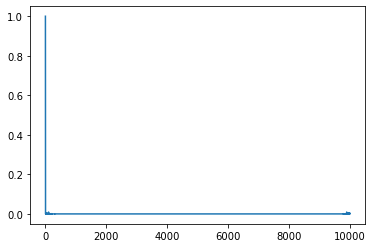

In [19]:
yy=fft(c1)
a=abs(yy)**2
a=MaxMinNormalization(a)
avea=1/10001*sum(a[0:10000])
stae=np.std(a)
plt.plot(a[0:-1])

使用sfgps和get_AFAGPS函数来完成计算

In [8]:
da=pd.read_csv(r'D:\e\南开光伏课题数据集及说明\NK2_GF\评测数据\气象数据\Station_1.csv')
da=np.array(da)
da
c1=da[0:10000,2]
c2=da[0:10000,3]
c3=da[0:10000,4]
c4=da[0:10000,5]
c5=da[0:10000,6]
#ax,ay=get_AFAGPS(c1,h=0.2)
#max_ay = max(ay)
#ay = [y / max_ay for y in ay]
#plt.figure(figsize=(40,10))
#plt.plot(ax,ay)

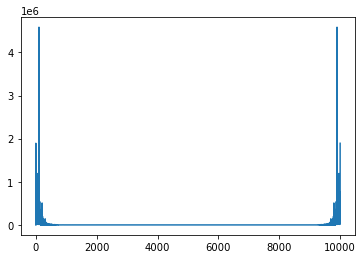

In [9]:
plt.plot(sfgps(c1))

In [13]:
import math

In [49]:
x=np.linspace(-1*np.pi,np.pi,10000)
y=[math.sqrt(m) for m in sfgps(c1)]
a=[[x],[y]]

In [53]:
wave=[]
for i in range(0,10000):
    ar=np.array(y[i]*np.cos(x))
    wave.append(ar)

In [54]:
wave

[array([-1.90007312, -1.90007274, -1.90007162, ..., -1.90007162,
        -1.90007274, -1.90007312]),
 array([-1375.60419903, -1375.60392744, -1375.60311268, ...,
        -1375.60311268, -1375.60392744, -1375.60419903]),
 array([-605.02219087, -605.02207142, -605.02171307, ..., -605.02171307,
        -605.02207142, -605.02219087]),
 array([-267.39944341, -267.39939061, -267.39923223, ..., -267.39923223,
        -267.39939061, -267.39944341]),
 array([-579.22726501, -579.22715066, -579.22680758, ..., -579.22680758,
        -579.22715066, -579.22726501]),
 array([-858.53682594, -858.53665643, -858.53614793, ..., -858.53614793,
        -858.53665643, -858.53682594]),
 array([-468.6634786 , -468.66338607, -468.66310848, ..., -468.66310848,
        -468.66338607, -468.6634786 ]),
 array([-873.70059131, -873.70041881, -873.69990132, ..., -873.69990132,
        -873.70041881, -873.70059131]),
 array([-486.63138965, -486.63129357, -486.63100534, ..., -486.63100534,
        -486.63129357, -486.6

In [52]:
sum(wave[:][1])

-1375.6041990233107

In [55]:
sumwave=[]
for i in range(0,10000):
    sumwave.append(sum(wave[:][i]))

In [56]:
sumwave

[-1.9000731187611288,
 -1375.6041990233107,
 -605.0221908761815,
 -267.3994434092449,
 -579.2272650092173,
 -858.536825935408,
 -468.6634785944705,
 -873.7005913118221,
 -486.631389652572,
 -338.563438129706,
 -816.8016302419982,
 -386.53922784230025,
 -355.410630141523,
 -501.62774828996817,
 -834.7149984036396,
 -208.73415968272613,
 -112.09678412943263,
 -762.836498053831,
 -282.5704284595647,
 -675.849080850001,
 -225.16880873409835,
 -435.0575090913778,
 -110.89787635499749,
 -367.8669088791193,
 -433.42582250451983,
 -559.6915787413234,
 -533.1567211256017,
 -281.6330292739409,
 -172.39724197178577,
 -278.69691478006905,
 -864.9825699513557,
 -729.2723463565502,
 -465.02424554587435,
 -695.3785081171314,
 -354.64737253923397,
 -114.27061446681209,
 -418.90529652822136,
 -410.6673271744756,
 -627.7163562377442,
 -449.99640741350873,
 -762.3643047820765,
 -1091.9026397411353,
 -675.406023796947,
 -334.1211258236031,
 -348.7460350329294,
 -429.474411574721,
 -698.8317637343389,
 -94

In [57]:
real=np.fft.ifft(sumwave).real

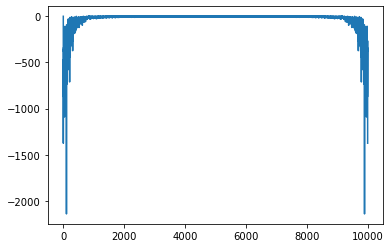

In [59]:
plt.plot(sumwave)

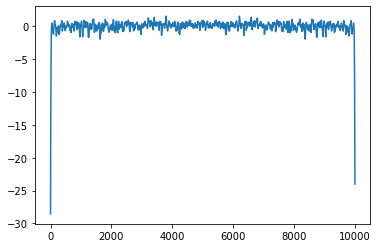

In [66]:
plt.plot(real)

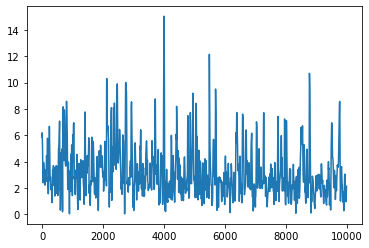

In [37]:
plt.plot(c1)

In [67]:
max(sumwave)

-1.3820685290223422